# Import Library

In [1]:
import csv
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

#Model
import transformers
from transformers import RobertaTokenizerFast,XLNetTokenizerFast, AlbertTokenizerFast
from transformers import TFRobertaModel,TFXLNetModel, TFAlbertModel
from xgboost import XGBClassifier

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words('english'))

# Helper Function

## Plot Training History

In [4]:
def plot_training_history(history):
    # Extracting values from history
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Number of epochs
    epochs = range(1, len(acc) + 1)

    # Find the best epoch for validation accuracy and loss
    best_epoch_acc = val_acc.index(max(val_acc)) + 1
    best_epoch_loss = val_loss.index(min(val_loss)) + 1

    # Plotting Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.axvline(best_epoch_acc, color='g', linestyle='--', label=f'Best Epoch (Acc): {best_epoch_acc}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.axvline(best_epoch_loss, color='g', linestyle='--', label=f'Best Epoch (Loss): {best_epoch_loss}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


## Check Max Length Tokenizer

In [5]:
#ROBERTA Tokenizer
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")
#XLNet Tokenizer
tokenizer_xlnet = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')
#ALBERT Tokenizer
tokenizer_albert = AlbertTokenizerFast.from_pretrained('albert-base-v2')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [6]:
def check_max_len_tokzenizer(tokenizer,data):
    token_lens = []
    for txt in data:
        tokens = tokenizer.encode(txt, max_length=100000, truncation=True)
        token_lens.append(len(tokens))
    return np.max(token_lens)

# Dataset

## ISEAR Dataset

In [7]:
isear_df = pd.read_excel('/kaggle/input/DATA.xlsx')
isear_df.head()

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE
0,11001,1,1,1,1,33,1,2,6,1,...,3,3,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1
1,11001,1,1,1,1,33,1,2,6,1,...,2,2,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1
2,11001,1,1,1,1,33,1,2,6,1,...,2,1,0,0,anger,1,3,110013,When I was driving home after several days of...,1
3,11001,1,1,1,1,33,1,2,6,1,...,1,1,0,2,sadness,4,4,110014,When I lost the person who meant the most to me.,1
4,11001,1,1,1,1,33,1,2,6,1,...,0,2,0,0,disgust,4,4,110015,The time I knocked a deer down - the sight of ...,1


In [8]:
isear_df['Field1'].value_counts()

Field1
anger      1096
disgust    1096
sadness    1096
shame      1096
fear       1095
joy        1094
guilt      1093
Name: count, dtype: int64

## Remove Unused Columns

In [9]:
column_to_keep = ['SIT','Field1']
isear_df = isear_df[column_to_keep]
isear_df.rename(columns={'Field1': 'Label'}, inplace=True)
isear_df.head()

,SIT,Label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust


In [10]:
# List of labels to keep
labels_to_keep = ['anger', 'disgust', 'sadness', 'fear', 'joy']

# Filter the DataFrame Preproc Data
filtered_df = isear_df[isear_df['Label'].isin(labels_to_keep)]
isear_df = isear_df[isear_df['Label'].isin(labels_to_keep)]
isear_df['Label'].value_counts()

Label
anger      1096
disgust    1096
sadness    1096
fear       1095
joy        1094
Name: count, dtype: int64

In [11]:
isear_df

,SIT,Label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7659,I received a letter from a distant friend.,joy
7660,My parents were out and I was the eldest at ho...,fear
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness


In [12]:
# Raw Dataset
isear_df_raw = isear_df.copy()
isear_df_raw

,SIT,Label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7659,I received a letter from a distant friend.,joy
7660,My parents were out and I was the eldest at ho...,fear
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness


### Cleaning Data

In [13]:
row_to_remove = [
    "Nothing.", 
    "None.", 
    "[ No response.]", 
    "NO RESPONSE.", 
    "[ No description.]",
]

phrase_to_remove = [
    'same as in',
    'same as for',
    'same as above',
]

# Define the function to check if text contains any phrase from the list
def contains_any_phrase(text, phrases):
    """Check if any phrase from the list exists in the text."""
    return any(phrase.lower() in text.lower() for phrase in phrases)

# Remove rows that match any entry in row_to_remove exactly
isear_df = isear_df[~isear_df["SIT"].str.strip().isin(row_to_remove)]

# Remove rows that contain any phrase from phrase_to_remove
isear_df = isear_df[~isear_df["SIT"].apply(lambda x: contains_any_phrase(x, phrase_to_remove))].reset_index(drop=True)

# Drop duplicates
isear_df = isear_df.drop_duplicates(subset='SIT')

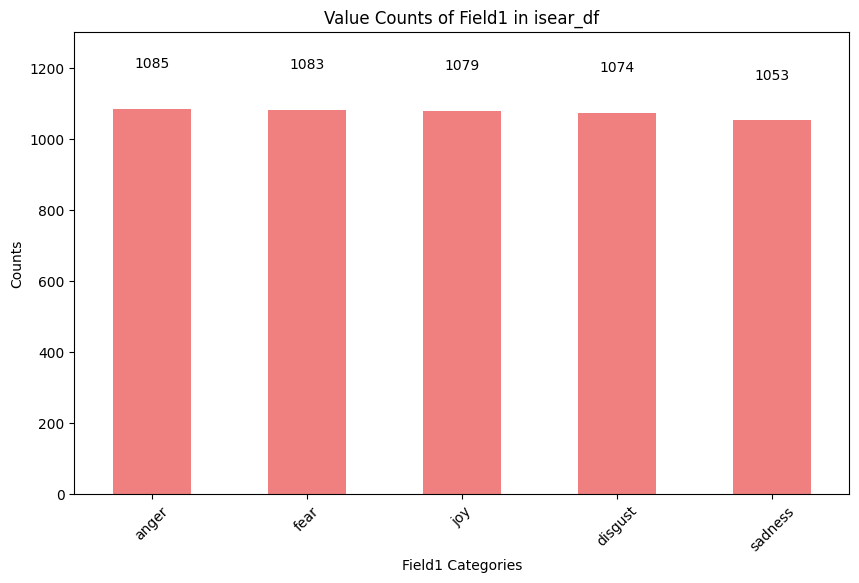

In [14]:
# Generate the value counts
value_counts = isear_df['Label'].value_counts()  # Assuming isear_df has a 'Field1' column

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = value_counts.plot(kind='bar', color='lightcoral')  # Customize color

# Add labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count + (count * 0.1), str(count), ha='center', va='bottom')  # Adjusting spacing dynamically

# Set y-axis limit to give more space above the bars
plt.ylim(0, value_counts.max() * 1.2)  # Increase the limit by 20%

plt.title('Value Counts of Field1 in isear_df')
plt.xlabel('Field1 Categories')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

## GoEmotion Dataset

In [15]:
goe_ds, goe_ds_info = tfds.load('goemotions', split='all', with_info=True)
goe_df_ori = tfds.as_dataframe(goe_ds, goe_ds_info)
goe_df_ori['comment_text'] = goe_df_ori['comment_text'].str.decode('utf-8')
goe_df = goe_df_ori.copy()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43410 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.9B42AY_0.1.0/goemotions-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/5426 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.9B42AY_0.1.0/goemotions-validation.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/5427 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/incomplete.9B42AY_0.1.0/goemotions-test.tfrecord*...:   0%|    …

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


### Preparation for Dataset

In [16]:
column_order = ['comment_text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear' , 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
# Preprocessed Data
goe_df = goe_df.reindex(columns = column_order)

In [17]:
#Dropmulti label
goe_df_multilabel_rows = goe_df[goe_df.iloc[:, 1:].sum(axis=1) > 1]
goe_df = goe_df.drop(index=goe_df_multilabel_rows.index)

In [18]:
# Remove label according to Ekman Principal ('anger',"disgust","joy","fear","sadness","surprise")
goe_column_to_keep = ['comment_text','anger',"disgust","joy","fear","sadness","surprise"]
goe_df = goe_df[goe_df[goe_column_to_keep[1:]].any(axis=1)][goe_column_to_keep]
goe_df.shape

(5410, 7)

In [19]:
def extract_label(row):
    for emotion in goe_df.columns[1:]:
        if row[emotion]:
            return emotion

# Apply the function to create the Label column
goe_df['Label'] = goe_df.apply(extract_label, axis=1)
# Select only the relevant columns
goe_df = goe_df[['comment_text', 'Label']]

In [20]:
goe_df.reset_index(drop=True, inplace=True)

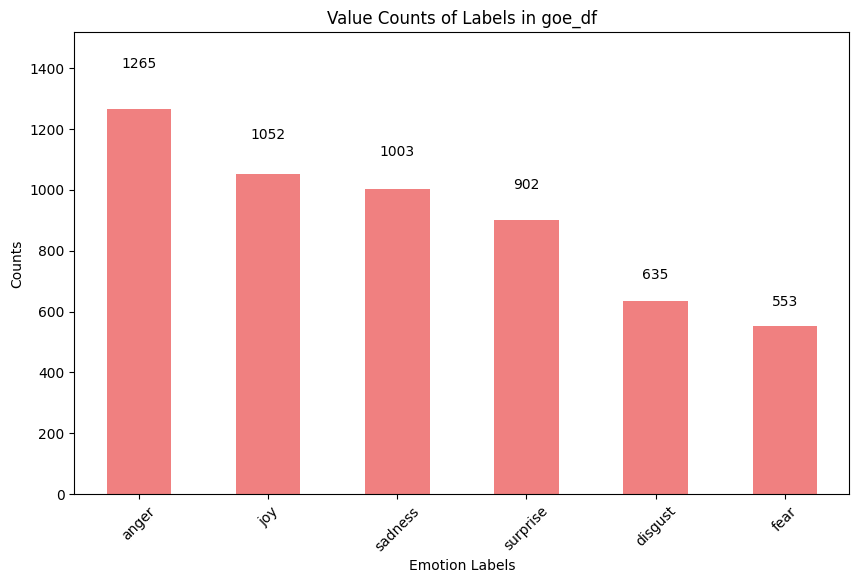

In [21]:
# Generate the value counts for the 'Label' column
value_counts = goe_df['Label'].value_counts()  # Assuming goe_df has a 'Label' column

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = value_counts.plot(kind='bar', color='lightcoral')  # Customize color

# Add labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count + (count * 0.1), str(count), ha='center', va='bottom')  # Adjusting spacing dynamically

# Set y-axis limit to give more space above the bars
plt.ylim(0, value_counts.max() * 1.2)  # Increase the limit by 20%

plt.title('Value Counts of Labels in goe_df')
plt.xlabel('Emotion Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

#### Raw Dataset

In [22]:
goe_df_raw = goe_df.copy()
goe_df_raw

,comment_text,Label
0,Same thing happened to me last year ended horr...,fear
1,I hate when people Beijing a gun. Even worse w...,anger
2,My husband and I have been circling the drain ...,sadness
3,That and customizable CSS makes me so happy. /...,joy
4,I'm missing something,sadness
...,...,...
5405,"THERE'S A WAR COMING, NED. I DON'T KNOW WHEN, ...",fear
5406,So that's how people get their cars sideways i...,surprise
5407,I wonder how fat activism intersects with anim...,surprise
5408,Absolutely. It's exhausting.,sadness


# Preprocessing Function

In [23]:
def clean_text(text):
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    # 3. Remove special characters
    text = re.sub(r'@\w+|[^A-Za-z0-9\s]', '', text)
    # 4. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 5. Remove stopwords
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# ISEAR Preprocessing

## Apply Preprocessing ISEAR

In [24]:
isear_df['SIT'] = isear_df['SIT'].apply(clean_text)

## Tokenisasi && Padding

In [25]:
MAX_LEN = 256 #Default

def tokenize(tokenizer, data, max_len = MAX_LEN):
  input_ids = []
  attention_masks = []
  for i in range(len(data)):
    encoded = tokenizer.encode_plus(
      data.iloc[i],
      add_special_tokens = True,
      max_length = max_len,
      padding = 'max_length',
      truncation = True,
      return_attention_mask = True
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids), np.array(attention_masks)

# Check Max Length For Raw and Preprocess Data ISEAR

In [26]:
## Preprocess
#RoBERTa Max Length
roberta_max = check_max_len_tokzenizer(tokenizer_roberta, isear_df['SIT'])
print(f"Roberta Max Length : {roberta_max}")
#XLNet Max Length
xlnet_max = check_max_len_tokzenizer(tokenizer_xlnet, isear_df['SIT'])
print(f"XLNet Max Length : {xlnet_max}")
#ALBERT Max Length
albert_max = check_max_len_tokzenizer(tokenizer_albert, isear_df['SIT'])
print(f"ALBERT Max Length : {albert_max}")

## Raw
#RoBERTa Max Length
roberta_max_raw = check_max_len_tokzenizer(tokenizer_roberta, isear_df_raw['SIT'])
print(f"Roberta Max Raw Length : {roberta_max_raw}")
#XLNet Max Length
xlnet_max_raw = check_max_len_tokzenizer(tokenizer_xlnet, isear_df_raw['SIT'])
print(f"XLNet Max Raw Length : {xlnet_max_raw}")
#ALBERT Max Length
albert_max_raw = check_max_len_tokzenizer(tokenizer_albert, isear_df_raw['SIT'])
print(f"ALBERT Max Raw Length : {albert_max_raw}")

Roberta Max Length : 85
XLNet Max Length : 88
ALBERT Max Length : 86
Roberta Max Raw Length : 242
XLNet Max Raw Length : 211
ALBERT Max Raw Length : 209


# Go Emotion Preprocessing

## Apply Preprocessing GoEmotion

In [27]:
goe_df['comment_text'] = goe_df['comment_text'].apply(clean_text)
goe_df.head()

,comment_text,Label
0,thing happened last year ended horribly,fear
1,hate people beijing gun even worse shanghai one,anger
2,husband circling drain years,sadness
3,customizable css makes happy rfirefoxcss youre...,joy
4,im missing something,sadness


# Check Max Length for Raw and Preprocess Data GoEmotion

In [28]:
## Preprocess
#RoBERTa Max Length
roberta_max_goe = check_max_len_tokzenizer(tokenizer_roberta, goe_df['comment_text'])
print(f"Roberta Max Length : {roberta_max_goe}")
#XLNet Max Length
xlnet_max_goe = check_max_len_tokzenizer(tokenizer_xlnet, goe_df['comment_text'])
print(f"XLNet Max Length : {xlnet_max_goe}")
#ALBERT Max Length
albert_max_goe = check_max_len_tokzenizer(tokenizer_albert, goe_df['comment_text'])
print(f"ALBERT Max Length : {albert_max_goe}")

## Raw
#RoBERTa Max Length
roberta_max_raw_goe = check_max_len_tokzenizer(tokenizer_roberta, goe_df_raw['comment_text'])
print(f"Roberta Max Raw Length : {roberta_max_raw_goe}")
#XLNet Max Length
xlnet_max_raw_goe = check_max_len_tokzenizer(tokenizer_xlnet, goe_df_raw['comment_text'])
print(f"XLNet Max Raw Length : {xlnet_max_raw_goe}")
#ALBERT Max Length
albert_max_raw_goe = check_max_len_tokzenizer(tokenizer_albert, goe_df_raw['comment_text'])
print(f"ALBERT Max Raw Length : {albert_max_raw_goe}")

Roberta Max Length : 42
XLNet Max Length : 77
ALBERT Max Length : 41
Roberta Max Raw Length : 51
XLNet Max Raw Length : 82
ALBERT Max Raw Length : 56


# Modelling

In [29]:
#ROBERTA Model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
#XLNet Model
xlnet_model = TFXLNetModel.from_pretrained("xlnet/xlnet-base-cased")
#ALBERT Model
albert_model = TFAlbertModel.from_pretrained('albert-base-v2')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet/xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of 

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


## Create Model Function

In [30]:
#Hyperparameter
LEARNING_RATE = 1e-5
DROPOUT_RATE = 0.3
OPTIMIZER = 'adam'
BATCH_SIZE = 16

In [31]:
#Model
def create_model(model_real, model_type, total_classes, learning_rate = 1e-5, dropout_rate = 0.3, max_len = MAX_LEN, optimizer = 'adam'):
    # Create a new instance of the model
    model = tf.keras.models.clone_model(model_real)    
    # Specify input shape to build the model
    model.build(input_shape=(None, max_len))
    # Copy the weights from the existing model
    model.set_weights(model_real.get_weights())
    # Select the optimizer based on the input
    if optimizer == 'adamw':
        opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    elif optimizer == 'adammax':
        opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32', name='input_ids')
    attention_mask = tf.keras.Input(shape=(max_len,),dtype='int32',name='attention_mask')
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    if model_type == 'roberta' or model_type == 'albert':
        output = output[1]
    elif model_type == 'xlnet':
        sequence_output  = output.last_hidden_state
        output = sequence_output[:, 0, :]
    # Add a hidden layer
    output = tf.keras.layers.Dropout(rate=dropout_rate)(output)
    output = tf.keras.layers.Dense(total_classes, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_mask],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

## Callback

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         
    patience=4,                 
    min_delta=1e-4,             
    restore_best_weights=True   
)

# Callback for Precision, Recall, and F1-Score per Epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_input_ids, val_attention_mask, val_labels = self.validation_data
        val_pred = self.model.predict([val_input_ids, val_attention_mask])

        # Get predicted classes (argmax) and true labels (argmax)
        val_pred_classes = np.argmax(val_pred, axis=1)
        val_true_classes = np.argmax(val_labels, axis=1)

        # Compute Precision, Recall, and F1-score
        precision = precision_score(val_true_classes, val_pred_classes, average='macro')
        recall = recall_score(val_true_classes, val_pred_classes, average='macro')
        f1 = f1_score(val_true_classes, val_pred_classes, average='macro')

        # Log Precision, Recall, and F1-score
        print(f"\nEpoch {epoch + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

        # Optionally store these metrics in the logs
        logs['val_precision'] = precision
        logs['val_recall'] = recall
        logs['val_f1_score'] = f1

In [33]:
class TimeHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Start time when training begins
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        # End time when training ends
        self.end_time = time.time()
        total_training_time = self.end_time - self.start_time
        
        # Optionally convert to minutes or hours
        minutes = total_training_time / 60
        hours = total_training_time / 3600
        
        # Print the total training time in seconds, minutes, and hours
        print(f"\nTotal training time: {total_training_time:.2f} seconds")
        print(f"Total training time: {minutes:.2f} minutes")
        print(f"Total training time: {hours:.2f} hours")

# Use the custom callback during model training
time_callback = TimeHistoryCallback()

### Create Training Function

In [34]:
def handle_roberta(dataset, dataset_type, train_x_fold, val_x_fold):
    """Helper function to handle the creation and tokenization of Roberta model."""
    if dataset == 'ISEAR':
        max_len = roberta_max if dataset_type == 'preprocess' else roberta_max_raw
    elif dataset == 'GOE':
        max_len = roberta_max_goe if dataset_type == 'preprocess' else roberta_max_raw_goe
    
    model = create_model(roberta_model, 'roberta', total_classes=(5 if dataset == 'ISEAR' else 6), max_len=max_len)
    train_input_ids, train_attention_masks = tokenize(tokenizer_roberta, train_x_fold, max_len=max_len)
    val_input_ids, val_attention_masks = tokenize(tokenizer_roberta, val_x_fold, max_len=max_len)

    return model, train_input_ids, train_attention_masks, val_input_ids, val_attention_masks


def handle_albert(dataset, dataset_type, train_x_fold, val_x_fold):
    """Helper function to handle the creation and tokenization of Albert model."""
    if dataset == 'ISEAR':
        max_len = albert_max if dataset_type == 'preprocess' else albert_max_raw
    elif dataset == 'GOE': 
        max_len = albert_max_goe if dataset_type == 'preprocess' else albert_max_raw_goe
    
    model = create_model(albert_model, 'albert', total_classes=(5 if dataset == 'ISEAR' else 6), max_len=max_len)
    train_input_ids, train_attention_masks = tokenize(tokenizer_albert, train_x_fold, max_len=max_len)
    val_input_ids, val_attention_masks = tokenize(tokenizer_albert, val_x_fold, max_len=max_len)

    return model, train_input_ids, train_attention_masks, val_input_ids, val_attention_masks


def log_metrics_per_epoch(fold, history, results_df, batch_size, fold_results):
    """Helper function to log training metrics per epoch."""
    for epoch in range(len(history.history['categorical_accuracy'])):
        train_accuracy = history.history['categorical_accuracy'][epoch]
        train_loss = history.history['loss'][epoch]
        val_accuracy = history.history['val_categorical_accuracy'][epoch]
        val_loss = history.history['val_loss'][epoch]
        precision = history.history['val_precision'][epoch]
        recall = history.history['val_recall'][epoch]
        f1 = history.history['val_f1_score'][epoch]

        # Prepare the row for CSV
        result_row = {
            'Batch Size': batch_size,
            'Fold': fold,
            'Epoch': epoch + 1,
            'Training Accuracy': train_accuracy,
            'Training Loss': train_loss,
            'Validation Accuracy': val_accuracy,
            'Validation Loss': val_loss,
            'Macro F1': f1,
            'Macro Precision': precision,
            'Macro Recall': recall
        }

        # Add to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

        # Append to fold results for averaging later
        fold_results['Training Accuracy'].append(train_accuracy)
        fold_results['Training Loss'].append(train_loss)
        fold_results['Validation Accuracy'].append(val_accuracy)
        fold_results['Validation Loss'].append(val_loss)
        fold_results['Macro F1'].append(f1)
        fold_results['Macro Precision'].append(precision)
        fold_results['Macro Recall'].append(recall)

    return results_df

In [35]:
def training_func_kfold(k=5, csv_filename=None, csv_columns=None, train_x=None, train_y=None, train_y_ohe=None, 
                        model_name='roberta', dataset=None, dataset_type=None, batch_size=16, 
                        learning_rate=None, dropout=None, optimizer=None):
    
    # Initialize StratifiedKFold
    results_df = pd.DataFrame(columns=csv_columns)
    skf = StratifiedKFold(n_splits=k, shuffle=False)
    fold_results = {
        'Training Accuracy': [],
        'Training Loss': [],
        'Validation Accuracy': [],
        'Validation Loss': [],
        'Macro F1': [],
        'Macro Precision': [],
        'Macro Recall': []
    }
    
    # Open CSV file to store results
    with open(csv_filename, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        
        # Loop through each fold
        for fold, (train_index, val_index) in enumerate(skf.split(train_x, train_y), 1):
            print(f'\nFold {fold}')

            # Create train and validation splits
            train_x_fold = train_x[train_index]
            val_x_fold = train_x[val_index]
            train_y_fold = train_y_ohe[train_index]
            val_y_fold = train_y_ohe[val_index]

            # Select and create model based on parameters
            if model_name == 'roberta':
                model, train_input_ids, train_attention_masks, val_input_ids, val_attention_masks = handle_roberta(
                    dataset, dataset_type, train_x_fold, val_x_fold)
            elif model_name == 'albert':
                model, train_input_ids, train_attention_masks, val_input_ids, val_attention_masks = handle_albert(
                    dataset, dataset_type, train_x_fold, val_x_fold)

            # Train the model
            history = model.fit(
                [train_input_ids, train_attention_masks],
                train_y_fold,
                validation_data=([val_input_ids, val_attention_masks], val_y_fold),
                epochs=10,
                batch_size=batch_size,
                shuffle=False,
                callbacks=[time_callback,
                           MetricsCallback(validation_data=(val_input_ids, val_attention_masks, val_y_fold))]
            )
            
            # Plot training history
            plot_training_history(history)

            # Log and save metrics per epoch
            results_df = log_metrics_per_epoch(fold, history, results_df, batch_size, fold_results)

        # Calculate and print averages across all folds
        avg_results = {metric: np.mean(values) for metric, values in fold_results.items()}
        print(f"\nAverage Results :")
        for metric, avg_value in avg_results.items():
            print(f"{metric}: {avg_value:.4f}")

    # Save results to CSV
    results_df.to_csv(csv_filename, index=False)
    print(f'Results saved to {csv_filename}')

# Train Test Split ISEAR

## Preprocessed ISEAR

In [36]:
isear_df_x = isear_df['SIT']
isear_df_y = isear_df['Label']

In [37]:
train_x, val_x, train_y, val_y = train_test_split(isear_df_x,isear_df_y , test_size = .2, random_state = 41, stratify = isear_df_y)
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size = .5, random_state = 41, stratify = val_y)

## Raw ISEAR

In [38]:
isear_df_raw_x = isear_df_raw['SIT']
isear_df_raw_y = isear_df_raw['Label']

In [39]:
train_x_raw, val_x_raw, train_y_raw, val_y_raw = train_test_split(isear_df_raw_x,isear_df_raw_y , test_size = .2, random_state = 41, stratify = isear_df_raw_y)
val_x_raw, test_x_raw, val_y_raw, test_y_raw = train_test_split(val_x_raw, val_y_raw, test_size = .5, random_state = 41, stratify = val_y_raw)

# Case 1: Testing Whether Preprocessing Affects Model Performance

# ISEAR Model Case 1

## One Hot Encoding Preprocessed

In [40]:
ohe = preprocessing.OneHotEncoder()
train_y_ohe  = ohe.fit_transform(np.array(train_y).reshape(-1, 1)).toarray()
val_y_ohe  = ohe.fit_transform(np.array(val_y).reshape(-1, 1)).toarray()
test_y_ohe  = ohe.fit_transform(np.array(test_y).reshape(-1, 1)).toarray()

In [41]:
train_x = train_x.reset_index(drop = True)
val_x = val_x.reset_index(drop = True)
test_x = test_x.reset_index(drop = True)

In [42]:
label_mapping = ohe.categories_[0]
print("Label Mapping:", label_mapping)

Label Mapping: ['anger' 'disgust' 'fear' 'joy' 'sadness']


## One Hot Encoding Raw

In [43]:
train_x_raw= train_x_raw.reset_index(drop = True)
val_x_raw = val_x_raw.reset_index(drop = True)
test_x_raw = test_x_raw.reset_index(drop = True)

In [44]:
train_y_ohe_raw  = ohe.fit_transform(np.array(train_y_raw).reshape(-1, 1)).toarray()
val_y_ohe_raw  = ohe.fit_transform(np.array(val_y_raw).reshape(-1, 1)).toarray()
test_y_ohe_raw  = ohe.fit_transform(np.array(test_y_raw).reshape(-1, 1)).toarray()

## Training on Preprocess Data

### RoBERTa


Fold 1
Epoch 1/10


I0000 00:00:1728539551.599899     122 service.cc:145] XLA service 0x7dfbf34fbf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728539551.599951     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728539551.599955     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728539551.788689     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 17s 176ms/step

Epoch 1 - Precision: 0.7479, Recall: 0.7414, F1-Score: 0.7398
215/215 [==============================] - 168s 451ms/step - loss: 1.2215 - categorical_accuracy: 0.4789 - val_loss: 0.7309 - val_categorical_accuracy: 0.7419 - precision: 0.7479 - recall: 0.7414 - f1_score: 0.7398
Epoch 2/10
27/27 [==============================] - 5s 178ms/step

Epoch 2 - Precision: 0.7376, Recall: 0.7395, F1-Score: 0.7379
215/215 [==============================] - 71s 332ms/step - loss: 0.7399 - categorical_accuracy: 0.7397 - val_loss: 0.7300 - val_categorical_accuracy: 0.7395 - precision: 0.7376 - recall: 0.7395 - f1_score: 0.7379
Epoch 3/10
27/27 [==============================] - 5s 179ms/step

Epoch 3 - Precision: 0.7406, Recall: 0.7418, F1-Score: 0.7383
215/215 [==============================] - 71s 331ms/step - loss: 0.5753 - categorical_accuracy: 0.8011 - val_loss: 0.7569 - val_categorical_accuracy: 0.7419 - precision: 0.7406 - recall: 0.7418

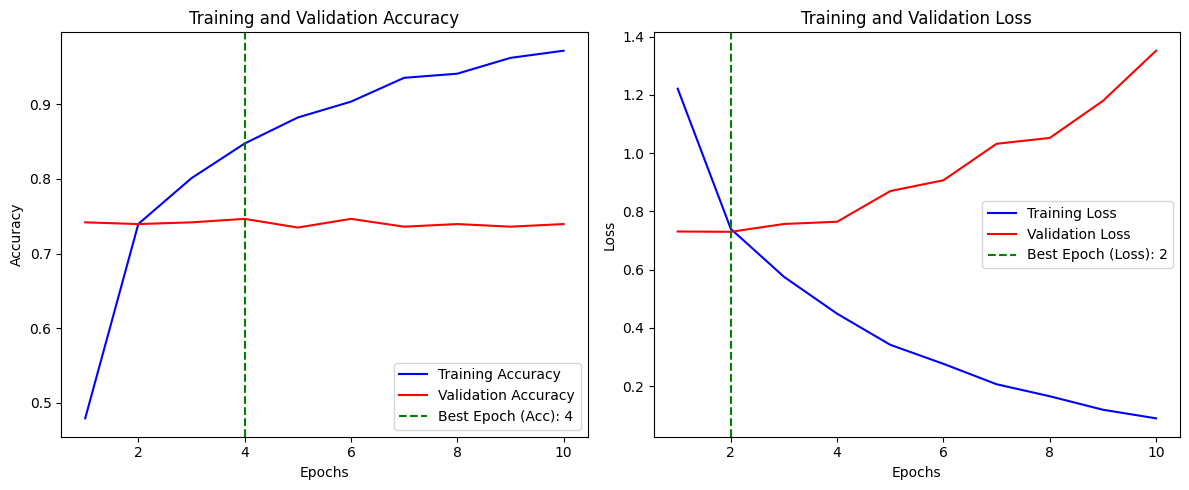

27/27 [==============================] - 5s 179ms/step


/tmp/ipykernel_30/4218778920.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row_df], ignore_index=True)


27/27 [==============================] - 5s 179ms/step

Fold 2
Epoch 1/10
27/27 [==============================] - 16s 176ms/step

Epoch 1 - Precision: 0.7355, Recall: 0.7290, F1-Score: 0.7281
215/215 [==============================] - 154s 446ms/step - loss: 1.2265 - categorical_accuracy: 0.4839 - val_loss: 0.7826 - val_categorical_accuracy: 0.7291 - precision: 0.7355 - recall: 0.7290 - f1_score: 0.7281
Epoch 2/10
27/27 [==============================] - 5s 177ms/step

Epoch 2 - Precision: 0.7445, Recall: 0.7375, F1-Score: 0.7389
215/215 [==============================] - 71s 331ms/step - loss: 0.7106 - categorical_accuracy: 0.7470 - val_loss: 0.7584 - val_categorical_accuracy: 0.7372 - precision: 0.7445 - recall: 0.7375 - f1_score: 0.7389
Epoch 3/10
27/27 [==============================] - 5s 178ms/step

Epoch 3 - Precision: 0.7255, Recall: 0.7267, F1-Score: 0.7246
215/215 [==============================] - 71s 330ms/step - loss: 0.5496 - categorical_accuracy: 0.8011 - val_loss: 0.77

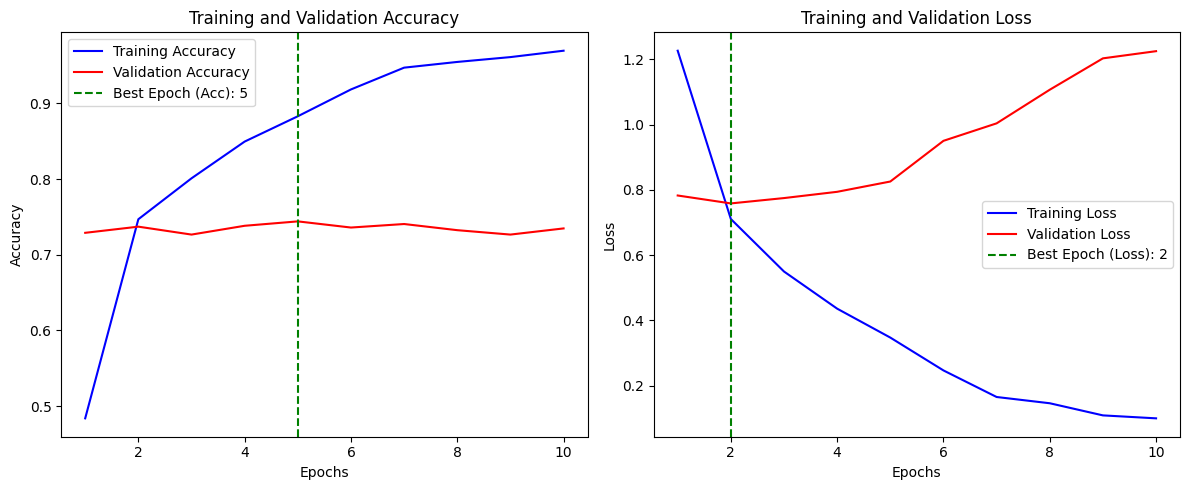

27/27 [==============================] - 5s 179ms/step

Fold 3
Epoch 1/10
27/27 [==============================] - 16s 176ms/step

Epoch 1 - Precision: 0.7370, Recall: 0.7324, F1-Score: 0.7311
215/215 [==============================] - 154s 446ms/step - loss: 1.2370 - categorical_accuracy: 0.4827 - val_loss: 0.7758 - val_categorical_accuracy: 0.7326 - precision: 0.7370 - recall: 0.7324 - f1_score: 0.7311
Epoch 2/10
27/27 [==============================] - 5s 177ms/step

Epoch 2 - Precision: 0.7527, Recall: 0.7514, F1-Score: 0.7514
215/215 [==============================] - 71s 330ms/step - loss: 0.7474 - categorical_accuracy: 0.7339 - val_loss: 0.7599 - val_categorical_accuracy: 0.7512 - precision: 0.7527 - recall: 0.7514 - f1_score: 0.7514
Epoch 3/10
27/27 [==============================] - 5s 178ms/step

Epoch 3 - Precision: 0.7643, Recall: 0.7630, F1-Score: 0.7629
215/215 [==============================] - 71s 330ms/step - loss: 0.5728 - categorical_accuracy: 0.7985 - val_loss: 0.73

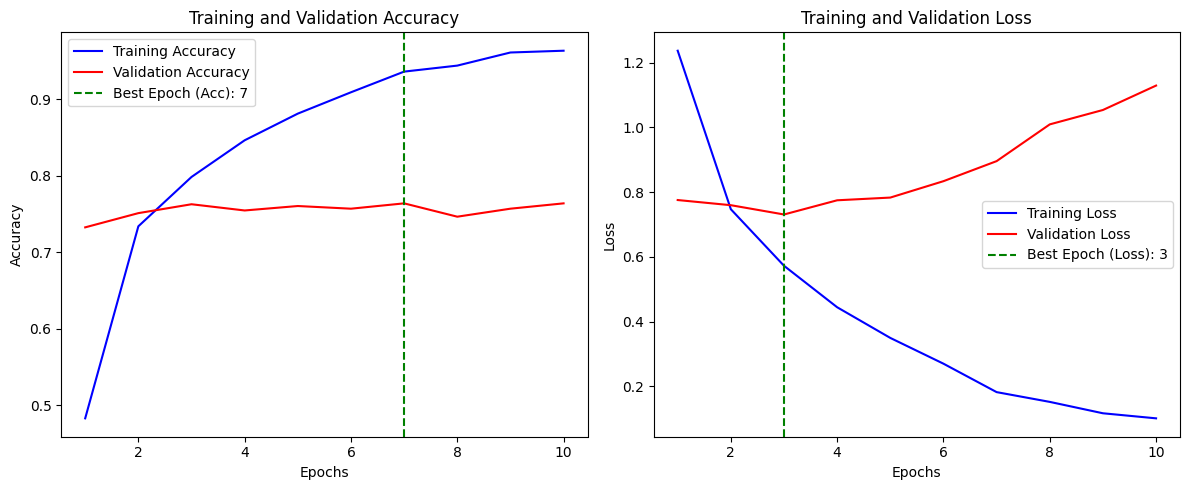

27/27 [==============================] - 5s 178ms/step

Fold 4
Epoch 1/10
27/27 [==============================] - 16s 177ms/step

Epoch 1 - Precision: 0.7071, Recall: 0.7061, F1-Score: 0.7032
215/215 [==============================] - 155s 445ms/step - loss: 1.1980 - categorical_accuracy: 0.5097 - val_loss: 0.8315 - val_categorical_accuracy: 0.7058 - precision: 0.7071 - recall: 0.7061 - f1_score: 0.7032
Epoch 2/10
27/27 [==============================] - 5s 177ms/step

Epoch 2 - Precision: 0.7242, Recall: 0.7202, F1-Score: 0.7195
215/215 [==============================] - 71s 330ms/step - loss: 0.7120 - categorical_accuracy: 0.7461 - val_loss: 0.8080 - val_categorical_accuracy: 0.7198 - precision: 0.7242 - recall: 0.7202 - f1_score: 0.7195
Epoch 3/10
27/27 [==============================] - 5s 179ms/step

Epoch 3 - Precision: 0.7325, Recall: 0.7317, F1-Score: 0.7292
215/215 [==============================] - 71s 329ms/step - loss: 0.5482 - categorical_accuracy: 0.8078 - val_loss: 0.85

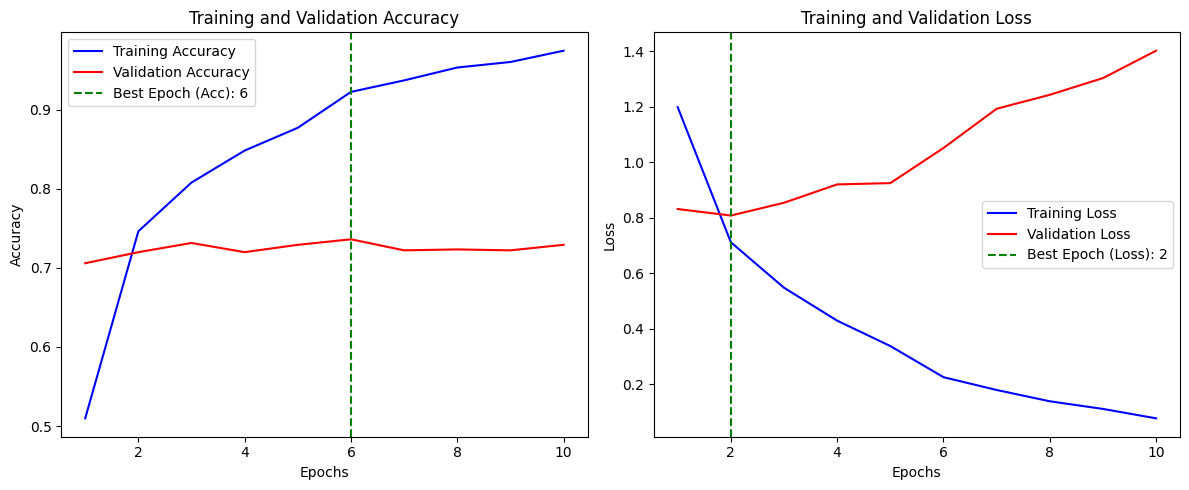

27/27 [==============================] - 5s 178ms/step

Fold 5
Epoch 1/10
27/27 [==============================] - 16s 175ms/step

Epoch 1 - Precision: 0.7078, Recall: 0.6898, F1-Score: 0.6934
215/215 [==============================] - 150s 469ms/step - loss: 1.1948 - categorical_accuracy: 0.5029 - val_loss: 0.8367 - val_categorical_accuracy: 0.6903 - precision: 0.7078 - recall: 0.6898 - f1_score: 0.6934
Epoch 2/10
27/27 [==============================] - 5s 178ms/step

Epoch 2 - Precision: 0.7427, Recall: 0.7295, F1-Score: 0.7321
215/215 [==============================] - 69s 322ms/step - loss: 0.7399 - categorical_accuracy: 0.7323 - val_loss: 0.7551 - val_categorical_accuracy: 0.7299 - precision: 0.7427 - recall: 0.7295 - f1_score: 0.7321
Epoch 3/10
27/27 [==============================] - 5s 178ms/step

Epoch 3 - Precision: 0.7382, Recall: 0.7202, F1-Score: 0.7238
215/215 [==============================] - 69s 321ms/step - loss: 0.5916 - categorical_accuracy: 0.7852 - val_loss: 0.79

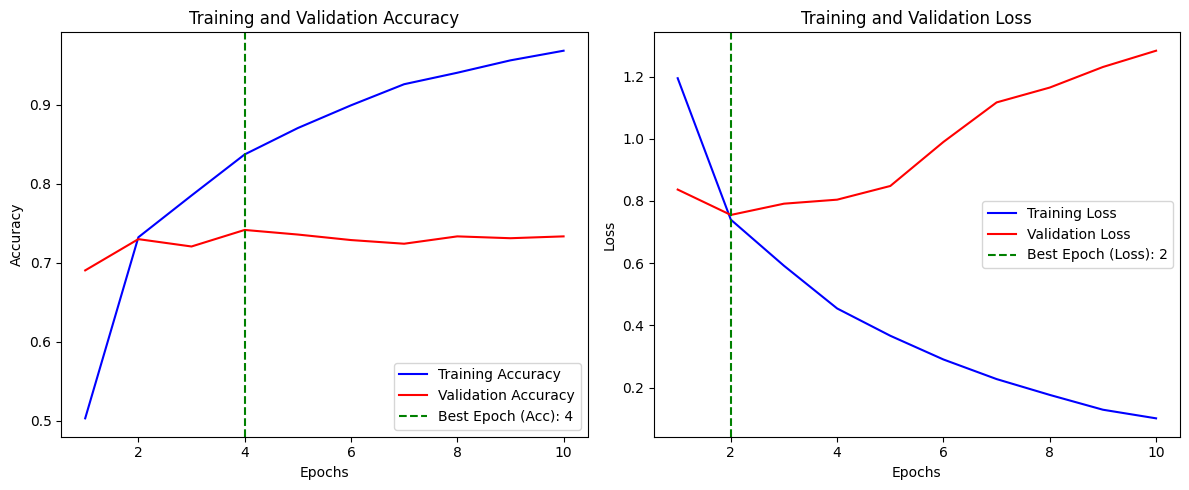

27/27 [==============================] - 5s 177ms/step

Average Results : 
Training Accuracy: 0.8479
Training Loss: 0.4125
Validation Accuracy: 0.7361
Validation Loss: 0.9580
Macro F1: 0.7407
Macro Precision: 0.7504
Macro Recall: 0.7400
Results saved to /kaggle/working/results_roberta_isear.csv


In [52]:
csv_filename = '/kaggle/working/results_roberta_isear.csv'
csv_columns = ['Batch Size','Fold', 'Epoch', 'Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 
               'Macro F1', 'Macro Precision', 'Macro Recall']

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=train_x,
    train_y=train_y,
    train_y_ohe=train_y_ohe,
    model_name='roberta',
    dataset='ISEAR',
    dataset_type='preprocess',
    batch_size=16
)

In [61]:
# isear_roberta_result = pd.read_csv('/kaggle/working/results_roberta_isear.csv')
isear_roberta_result

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.478918,1.221527,0.741860,0.730938,0.740449,0.760775,0.739276
1,16,1,2,0.739750,0.739857,0.739535,0.730011,0.740449,0.760775,0.739276
2,16,1,3,0.801105,0.575303,0.741860,0.756866,0.740449,0.760775,0.739276
3,16,1,4,0.847630,0.448575,0.746512,0.764590,0.740449,0.760775,0.739276
4,16,1,5,0.882524,0.341768,0.734884,0.869862,0.740449,0.760775,0.739276
5,16,1,6,0.903751,0.276459,0.746512,0.907034,0.740449,0.760775,0.739276
6,16,1,7,0.935737,0.206368,0.736046,1.032343,0.740449,0.760775,0.739276
7,16,1,8,0.941262,0.165158,0.739535,1.052375,0.740449,0.760775,0.739276
8,16,1,9,0.962489,0.118845,0.736046,1.179609,0.740449,0.760775,0.739276
9,16,1,10,0.972085,0.089304,0.739535,1.351928,0.740449,0.760775,0.739276


### ALBERT


Fold 1
Epoch 1/10
27/27 [==============================] - 14s 196ms/step

Epoch 1 - Precision: 0.5663, Recall: 0.5302, F1-Score: 0.5073
215/215 [==============================] - 117s 406ms/step - loss: 1.6303 - categorical_accuracy: 0.2896 - val_loss: 1.2175 - val_categorical_accuracy: 0.5314 - val_precision: 0.5663 - val_recall: 0.5302 - val_f1_score: 0.5073
Epoch 2/10
27/27 [==============================] - 5s 198ms/step

Epoch 2 - Precision: 0.7103, Recall: 0.7054, F1-Score: 0.7041
215/215 [==============================] - 70s 324ms/step - loss: 1.0262 - categorical_accuracy: 0.6022 - val_loss: 0.7979 - val_categorical_accuracy: 0.7058 - val_precision: 0.7103 - val_recall: 0.7054 - val_f1_score: 0.7041
Epoch 3/10
27/27 [==============================] - 5s 200ms/step

Epoch 3 - Precision: 0.7319, Recall: 0.7290, F1-Score: 0.7292
215/215 [==============================] - 69s 323ms/step - loss: 0.7449 - categorical_accuracy: 0.7275 - val_loss: 0.7682 - val_categorical_accuracy: 

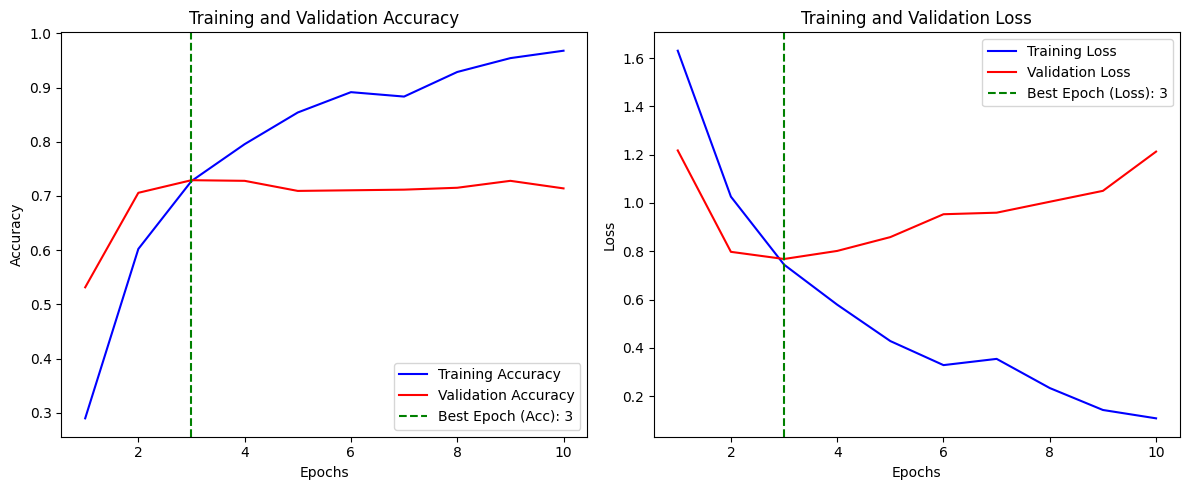

/tmp/ipykernel_29/2907990659.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)



Fold 2
Epoch 1/10
27/27 [==============================] - 14s 196ms/step

Epoch 1 - Precision: 0.6385, Recall: 0.6325, F1-Score: 0.6254
215/215 [==============================] - 114s 404ms/step - loss: 1.4314 - categorical_accuracy: 0.4030 - val_loss: 0.9902 - val_categorical_accuracy: 0.6326 - val_precision: 0.6385 - val_recall: 0.6325 - val_f1_score: 0.6254
Epoch 2/10
27/27 [==============================] - 5s 198ms/step

Epoch 2 - Precision: 0.6819, Recall: 0.6783, F1-Score: 0.6744
215/215 [==============================] - 70s 324ms/step - loss: 0.8774 - categorical_accuracy: 0.6915 - val_loss: 0.8720 - val_categorical_accuracy: 0.6779 - val_precision: 0.6819 - val_recall: 0.6783 - val_f1_score: 0.6744
Epoch 3/10
27/27 [==============================] - 5s 200ms/step

Epoch 3 - Precision: 0.6943, Recall: 0.6885, F1-Score: 0.6865
215/215 [==============================] - 69s 322ms/step - loss: 0.6917 - categorical_accuracy: 0.7592 - val_loss: 0.9100 - val_categorical_accuracy: 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 [==============================] - 5s 197ms/step

Epoch 9 - Precision: 0.0405, Recall: 0.2000, F1-Score: 0.0673
215/215 [==============================] - 69s 320ms/step - loss: 1.6565 - categorical_accuracy: 0.1972 - val_loss: 1.6102 - val_categorical_accuracy: 0.2023 - val_precision: 0.0405 - val_recall: 0.2000 - val_f1_score: 0.0673
Epoch 10/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 [==============================] - 5s 197ms/step

Epoch 10 - Precision: 0.0405, Recall: 0.2000, F1-Score: 0.0673
215/215 [==============================] - 69s 321ms/step - loss: 1.6486 - categorical_accuracy: 0.1948 - val_loss: 1.6105 - val_categorical_accuracy: 0.2023 - val_precision: 0.0405 - val_recall: 0.2000 - val_f1_score: 0.0673

Total training time: 737.04 seconds
Total training time: 12.28 minutes
Total training time: 0.20 hours


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


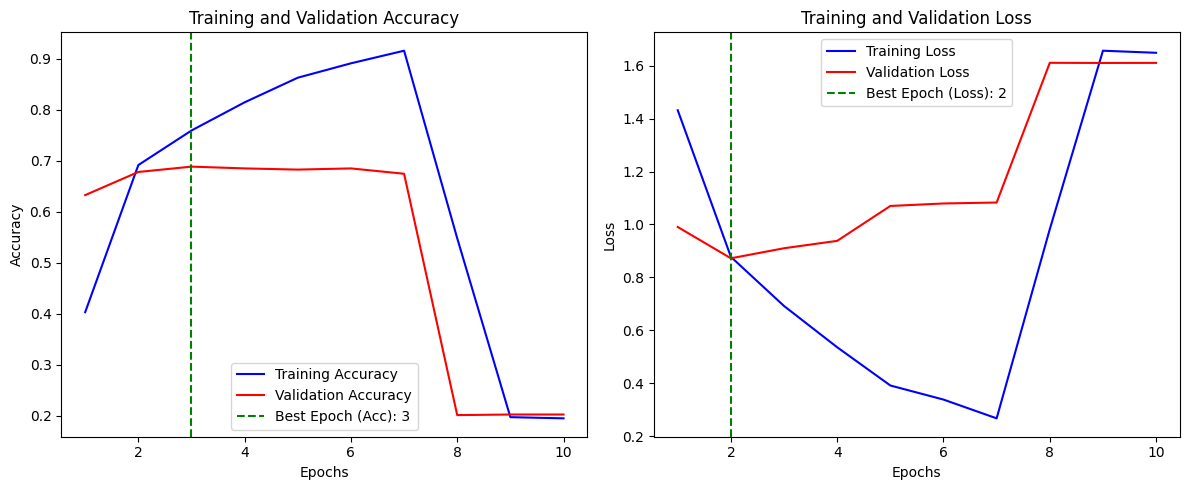


Fold 3
Epoch 1/10
27/27 [==============================] - 14s 194ms/step

Epoch 1 - Precision: 0.0402, Recall: 0.2000, F1-Score: 0.0670
215/215 [==============================] - 116s 407ms/step - loss: 1.7402 - categorical_accuracy: 0.2047 - val_loss: 1.6284 - val_categorical_accuracy: 0.2012 - val_precision: 0.0402 - val_recall: 0.2000 - val_f1_score: 0.0670
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 [==============================] - 5s 196ms/step

Epoch 2 - Precision: 0.0858, Recall: 0.2111, F1-Score: 0.1029
215/215 [==============================] - 69s 322ms/step - loss: 1.7166 - categorical_accuracy: 0.1977 - val_loss: 1.6144 - val_categorical_accuracy: 0.2116 - val_precision: 0.0858 - val_recall: 0.2111 - val_f1_score: 0.1029
Epoch 3/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 [==============================] - 5s 198ms/step

Epoch 3 - Precision: 0.2203, Recall: 0.3690, F1-Score: 0.2739
215/215 [==============================] - 69s 321ms/step - loss: 1.6597 - categorical_accuracy: 0.2265 - val_loss: 1.4766 - val_categorical_accuracy: 0.3686 - val_precision: 0.2203 - val_recall: 0.3690 - val_f1_score: 0.2739
Epoch 4/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27/27 [==============================] - 5s 200ms/step

Epoch 4 - Precision: 0.3874, Recall: 0.4112, F1-Score: 0.3854
215/215 [==============================] - 69s 322ms/step - loss: 1.5000 - categorical_accuracy: 0.3283 - val_loss: 1.3457 - val_categorical_accuracy: 0.4116 - val_precision: 0.3874 - val_recall: 0.4112 - val_f1_score: 0.3854
Epoch 5/10
27/27 [==============================] - 5s 200ms/step

Epoch 5 - Precision: 0.6040, Recall: 0.5945, F1-Score: 0.5887
215/215 [==============================] - 69s 322ms/step - loss: 1.2178 - categorical_accuracy: 0.4862 - val_loss: 1.1032 - val_categorical_accuracy: 0.5953 - val_precision: 0.6040 - val_recall: 0.5945 - val_f1_score: 0.5887
Epoch 6/10
27/27 [==============================] - 5s 199ms/step

Epoch 6 - Precision: 0.6462, Recall: 0.6392, F1-Score: 0.6303
215/215 [==============================] - 69s 321ms/step - loss: 0.9325 - categorical_accuracy: 0.6572 - val_loss: 1.1427 - val_categorical_accuracy: 0.6384 - val_precisio

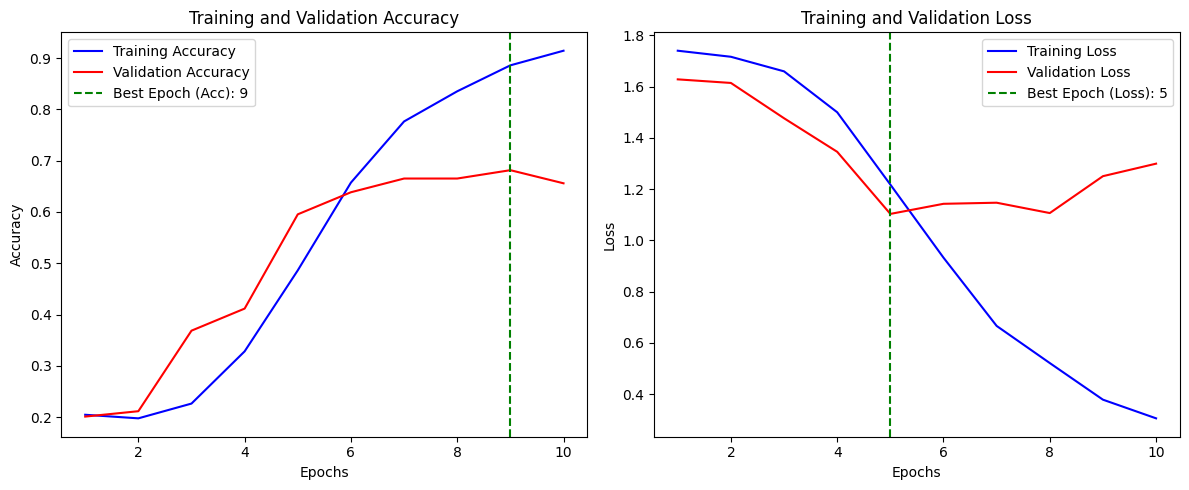


Fold 4
Epoch 1/10
27/27 [==============================] - 15s 196ms/step

Epoch 1 - Precision: 0.5473, Recall: 0.5335, F1-Score: 0.5131
215/215 [==============================] - 115s 411ms/step - loss: 1.6132 - categorical_accuracy: 0.2922 - val_loss: 1.1908 - val_categorical_accuracy: 0.5337 - val_precision: 0.5473 - val_recall: 0.5335 - val_f1_score: 0.5131
Epoch 2/10
27/27 [==============================] - 5s 198ms/step

Epoch 2 - Precision: 0.7015, Recall: 0.7015, F1-Score: 0.7004
215/215 [==============================] - 69s 323ms/step - loss: 1.0587 - categorical_accuracy: 0.6002 - val_loss: 0.8157 - val_categorical_accuracy: 0.7012 - val_precision: 0.7015 - val_recall: 0.7015 - val_f1_score: 0.7004
Epoch 3/10
27/27 [==============================] - 5s 199ms/step

Epoch 3 - Precision: 0.7142, Recall: 0.7119, F1-Score: 0.7075
215/215 [==============================] - 69s 322ms/step - loss: 0.7575 - categorical_accuracy: 0.7325 - val_loss: 0.8331 - val_categorical_accuracy: 

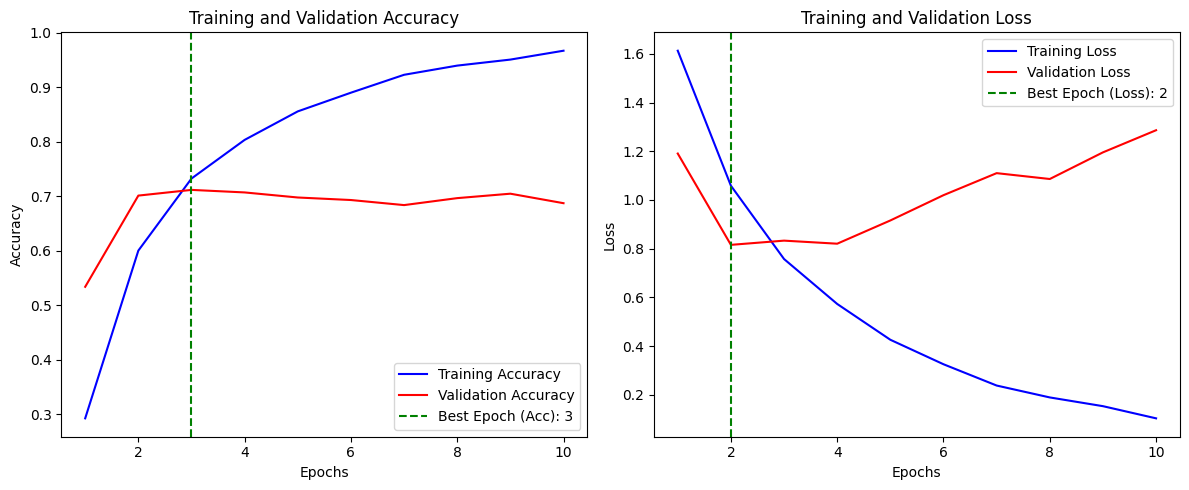


Fold 5
Epoch 1/10
27/27 [==============================] - 14s 195ms/step

Epoch 1 - Precision: 0.6509, Recall: 0.6082, F1-Score: 0.6090
215/215 [==============================] - 106s 395ms/step - loss: 1.3915 - categorical_accuracy: 0.4154 - val_loss: 1.0519 - val_categorical_accuracy: 0.6088 - val_precision: 0.6509 - val_recall: 0.6082 - val_f1_score: 0.6090
Epoch 2/10
27/27 [==============================] - 5s 198ms/step

Epoch 2 - Precision: 0.7191, Recall: 0.7015, F1-Score: 0.7050
215/215 [==============================] - 68s 316ms/step - loss: 0.8426 - categorical_accuracy: 0.6884 - val_loss: 0.8297 - val_categorical_accuracy: 0.7020 - val_precision: 0.7191 - val_recall: 0.7015 - val_f1_score: 0.7050
Epoch 3/10
27/27 [==============================] - 5s 199ms/step

Epoch 3 - Precision: 0.7169, Recall: 0.7094, F1-Score: 0.7104
215/215 [==============================] - 67s 314ms/step - loss: 0.6432 - categorical_accuracy: 0.7712 - val_loss: 0.8124 - val_categorical_accuracy: 

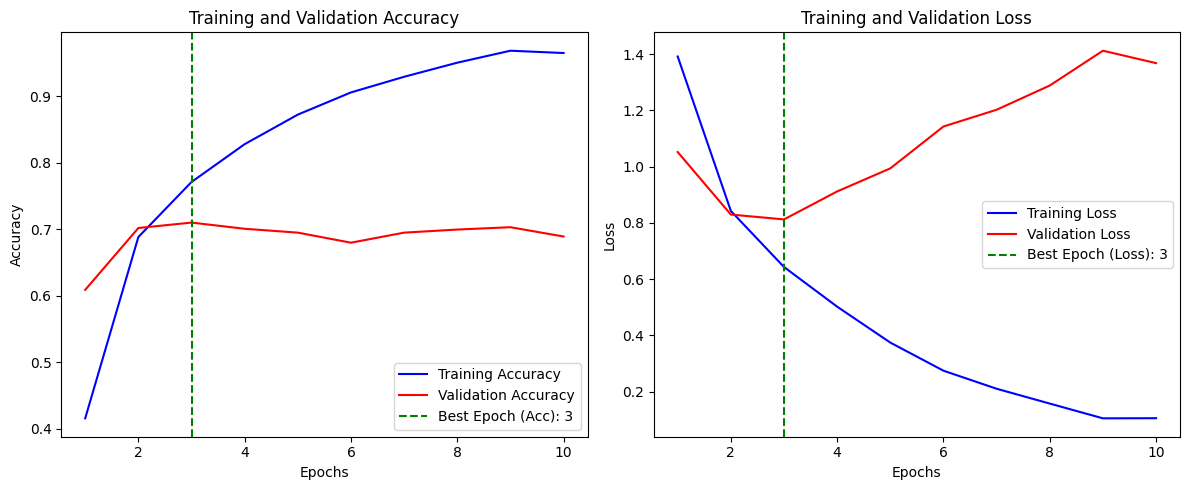


Average Results :
Training Accuracy: 0.7187
Training Loss: 0.7016
Validation Accuracy: 0.6222
Validation Loss: 1.1160
Macro F1: 0.6056
Macro Precision: 0.6122
Macro Recall: 0.6220
Results saved to /kaggle/working/results_albert_isear.csv


In [60]:
csv_filename = '/kaggle/working/results_albert_isear.csv'
csv_columns = ['Batch Size','Fold', 'Epoch', 'Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 
               'Macro F1', 'Macro Precision', 'Macro Recall']

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=train_x,
    train_y=train_y,
    train_y_ohe=train_y_ohe,
    model_name='albert',
    dataset='ISEAR',
    dataset_type='preprocess',
    batch_size=16
)

In [61]:
isear_albert_result = pd.read_csv('/kaggle/working/results_albert_isear.csv')
isear_albert_result

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.289619,1.630325,0.531395,1.217532,0.507276,0.566298,0.530173
1,16,1,2,0.602210,1.026238,0.705814,0.797856,0.704054,0.710338,0.705449
2,16,1,3,0.727537,0.744937,0.729070,0.768230,0.729162,0.731857,0.728972
3,16,1,4,0.795580,0.579126,0.727907,0.801635,0.725824,0.730100,0.727751
4,16,1,5,0.854027,0.428480,0.709302,0.858865,0.708663,0.715230,0.709479
5,16,1,6,0.891538,0.328954,0.710465,0.953504,0.711287,0.718353,0.710463
6,16,1,7,0.883396,0.354771,0.711628,0.959900,0.711329,0.722753,0.711545
7,16,1,8,0.928758,0.234016,0.715116,1.005155,0.710863,0.715911,0.715212
8,16,1,9,0.954347,0.143241,0.727907,1.050316,0.725797,0.736844,0.727683
9,16,1,10,0.968014,0.108662,0.713953,1.212754,0.715807,0.730261,0.713987


## Training on RAW Data

In [ ]:
import gc 
import torch
tf.keras.backend.clear_session()
torch.cuda.empty_cache()

### RoBERTa


Fold 1
Epoch 1/10


I0000 00:00:1728563483.838993     113 service.cc:145] XLA service 0x7a21c780e8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728563483.839052     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728563483.839056     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728563484.018904     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 26s 510ms/step

Epoch 1 - Precision: 0.7494, Recall: 0.7378, F1-Score: 0.7402
219/219 [==============================] - 295s 1s/step - loss: 1.1036 - categorical_accuracy: 0.5434 - val_loss: 0.7103 - val_categorical_accuracy: 0.7377 - val_precision: 0.7494 - val_recall: 0.7378 - val_f1_score: 0.7402
Epoch 2/10
28/28 [==============================] - 14s 503ms/step

Epoch 2 - Precision: 0.7767, Recall: 0.7755, F1-Score: 0.7759
219/219 [==============================] - 199s 908ms/step - loss: 0.5699 - categorical_accuracy: 0.7997 - val_loss: 0.6226 - val_categorical_accuracy: 0.7754 - val_precision: 0.7767 - val_recall: 0.7755 - val_f1_score: 0.7759
Epoch 3/10
28/28 [==============================] - 14s 502ms/step

Epoch 3 - Precision: 0.7927, Recall: 0.7834, F1-Score: 0.7855
219/219 [==============================] - 198s 907ms/step - loss: 0.4162 - categorical_accuracy: 0.8519 - val_loss: 0.6834 - val_categorical_accuracy: 0.7834 - val_preci

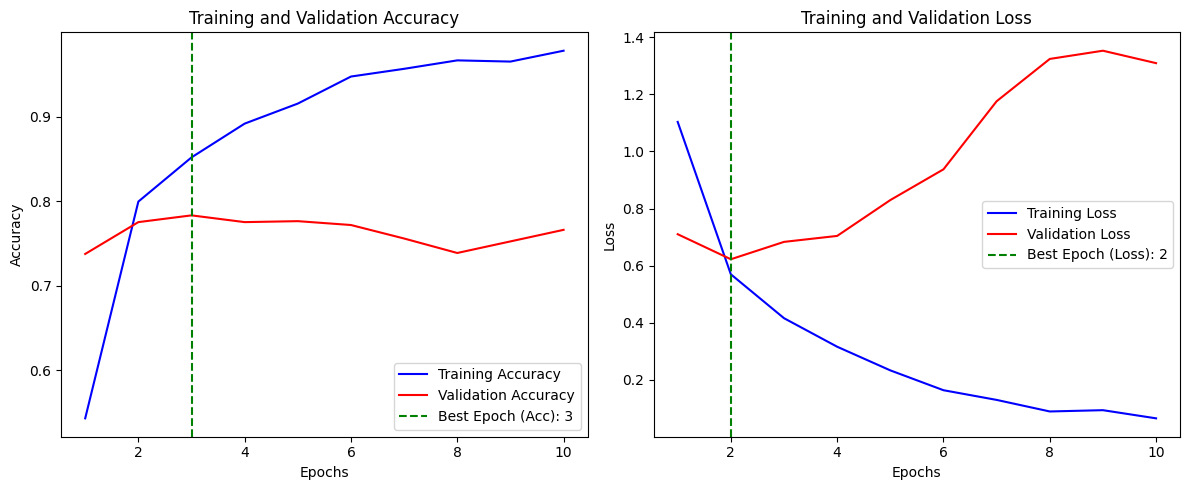

/tmp/ipykernel_30/2575389729.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row_df], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 25s 511ms/step

Epoch 1 - Precision: 0.7939, Recall: 0.7821, F1-Score: 0.7833
220/220 [==============================] - 282s 1s/step - loss: 1.0981 - categorical_accuracy: 0.5398 - val_loss: 0.6225 - val_categorical_accuracy: 0.7820 - val_precision: 0.7939 - val_recall: 0.7821 - val_f1_score: 0.7833
Epoch 2/10
28/28 [==============================] - 14s 502ms/step

Epoch 2 - Precision: 0.7957, Recall: 0.7877, F1-Score: 0.7903
220/220 [==============================] - 202s 917ms/step - loss: 0.5491 - categorical_accuracy: 0.8100 - val_loss: 0.5858 - val_categorical_accuracy: 0.7877 - val_precision: 0.7957 - val_recall: 0.7877 - val_f1_score: 0.7903
Epoch 3/10
28/28 [==============================] - 14s 503ms/step

Epoch 3 - Precision: 0.7881, Recall: 0.7889, F1-Score: 0.7879
220/220 [==============================] - 202s 917ms/step - loss: 0.4253 - categorical_accuracy: 0.8485 - val_loss: 0.6120 - val_categorical_accuracy:

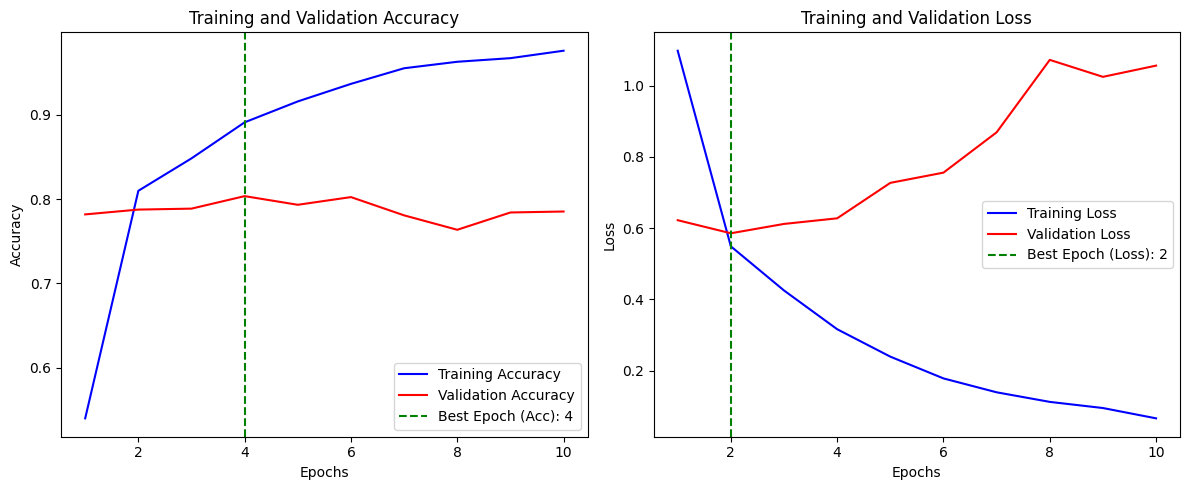


Fold 3
Epoch 1/10
28/28 [==============================] - 27s 510ms/step

Epoch 1 - Precision: 0.8027, Recall: 0.7854, F1-Score: 0.7840
220/220 [==============================] - 283s 1s/step - loss: 1.1028 - categorical_accuracy: 0.5358 - val_loss: 0.6142 - val_categorical_accuracy: 0.7854 - val_precision: 0.8027 - val_recall: 0.7854 - val_f1_score: 0.7840
Epoch 2/10
28/28 [==============================] - 14s 504ms/step

Epoch 2 - Precision: 0.7977, Recall: 0.7979, F1-Score: 0.7976
220/220 [==============================] - 202s 918ms/step - loss: 0.5751 - categorical_accuracy: 0.7880 - val_loss: 0.5586 - val_categorical_accuracy: 0.7979 - val_precision: 0.7977 - val_recall: 0.7979 - val_f1_score: 0.7976
Epoch 3/10
28/28 [==============================] - 14s 501ms/step

Epoch 3 - Precision: 0.8105, Recall: 0.8105, F1-Score: 0.8102
220/220 [==============================] - 207s 943ms/step - loss: 0.4233 - categorical_accuracy: 0.8534 - val_loss: 0.5659 - val_categorical_accuracy:

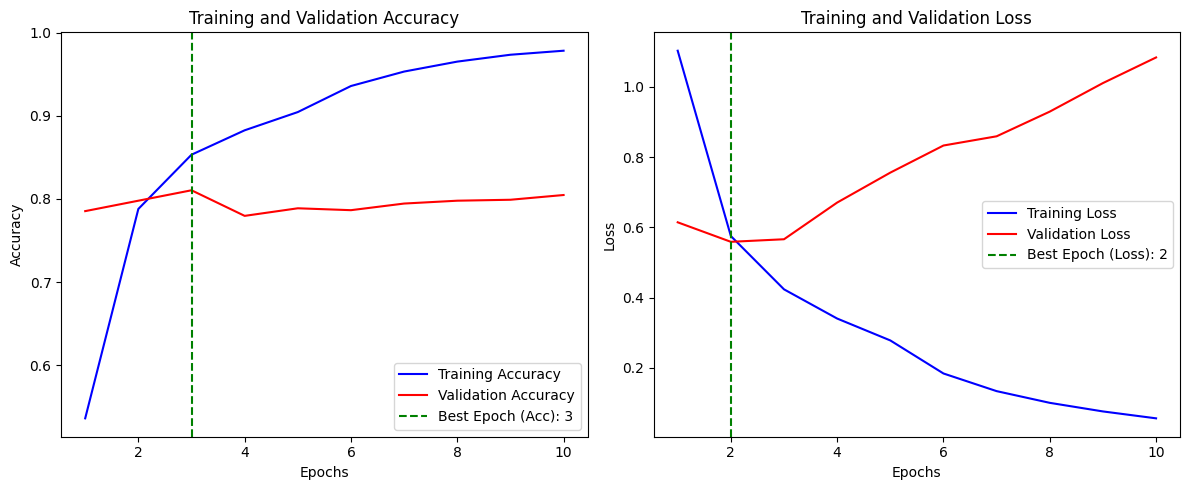


Fold 4
Epoch 1/10
28/28 [==============================] - 25s 510ms/step

Epoch 1 - Precision: 0.7935, Recall: 0.7763, F1-Score: 0.7772
220/220 [==============================] - 279s 1s/step - loss: 1.1646 - categorical_accuracy: 0.5116 - val_loss: 0.6354 - val_categorical_accuracy: 0.7763 - val_precision: 0.7935 - val_recall: 0.7763 - val_f1_score: 0.7772
Epoch 2/10
28/28 [==============================] - 14s 502ms/step

Epoch 2 - Precision: 0.8050, Recall: 0.7968, F1-Score: 0.7996
220/220 [==============================] - 201s 915ms/step - loss: 0.5798 - categorical_accuracy: 0.7937 - val_loss: 0.6145 - val_categorical_accuracy: 0.7968 - val_precision: 0.8050 - val_recall: 0.7968 - val_f1_score: 0.7996
Epoch 3/10
28/28 [==============================] - 14s 503ms/step

Epoch 3 - Precision: 0.7994, Recall: 0.7866, F1-Score: 0.7903
220/220 [==============================] - 201s 915ms/step - loss: 0.4338 - categorical_accuracy: 0.8462 - val_loss: 0.6730 - val_categorical_accuracy:

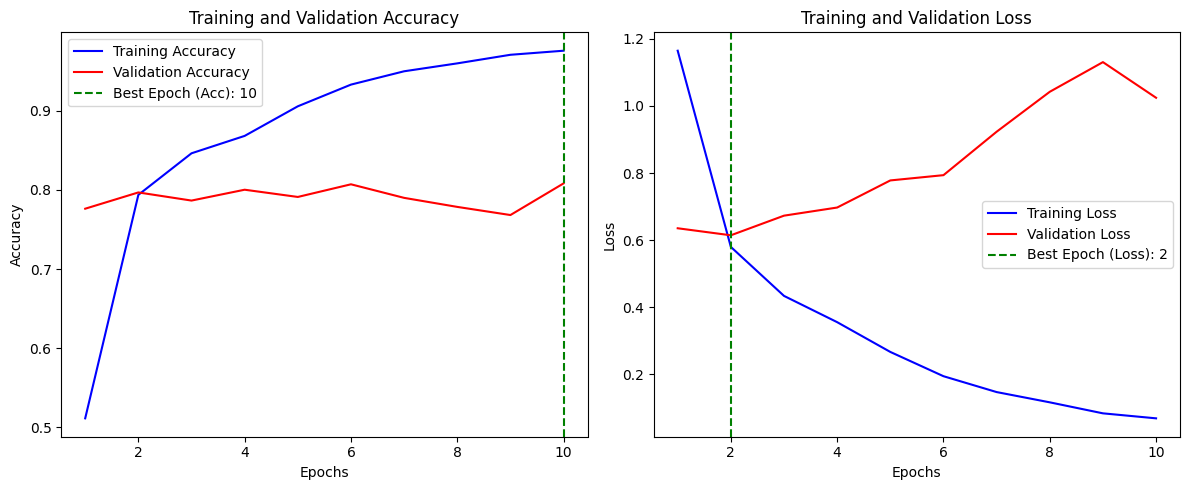


Fold 5
Epoch 1/10
28/28 [==============================] - 26s 509ms/step

Epoch 1 - Precision: 0.8003, Recall: 0.7820, F1-Score: 0.7839
220/220 [==============================] - 280s 1s/step - loss: 1.1001 - categorical_accuracy: 0.5341 - val_loss: 0.6289 - val_categorical_accuracy: 0.7820 - val_precision: 0.8003 - val_recall: 0.7820 - val_f1_score: 0.7839
Epoch 2/10
28/28 [==============================] - 14s 501ms/step

Epoch 2 - Precision: 0.7988, Recall: 0.7866, F1-Score: 0.7868
220/220 [==============================] - 202s 917ms/step - loss: 0.5705 - categorical_accuracy: 0.7932 - val_loss: 0.6045 - val_categorical_accuracy: 0.7865 - val_precision: 0.7988 - val_recall: 0.7866 - val_f1_score: 0.7868
Epoch 3/10
28/28 [==============================] - 14s 501ms/step

Epoch 3 - Precision: 0.8016, Recall: 0.8025, F1-Score: 0.8007
220/220 [==============================] - 201s 915ms/step - loss: 0.4132 - categorical_accuracy: 0.8591 - val_loss: 0.6464 - val_categorical_accuracy:

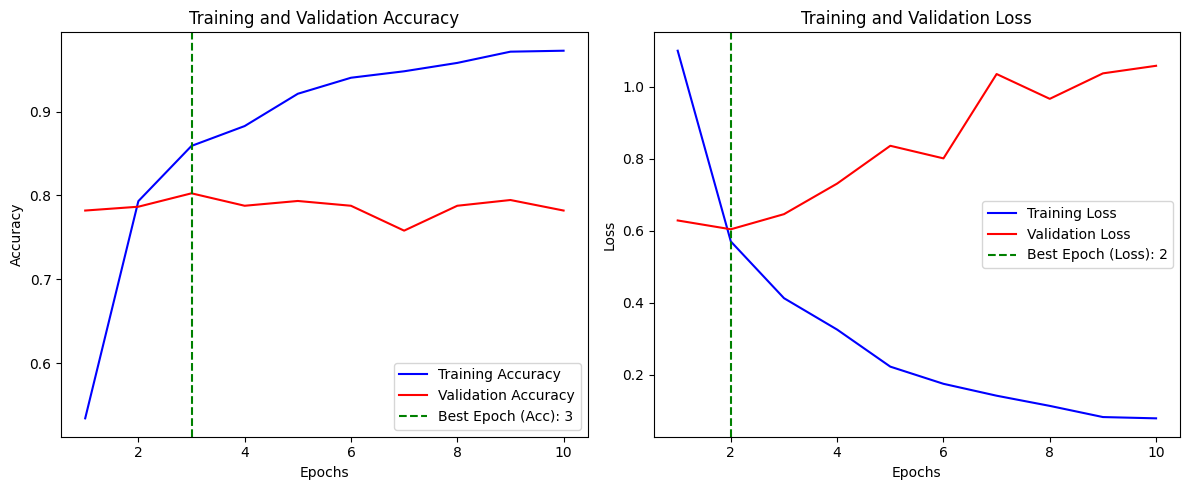

Training Accuracy: 0.8778
Training Loss: 0.3262
Validation Accuracy: 0.7843
Validation Loss: 0.8428
Macro F1: 0.7834
Macro Precision: 0.7896
Macro Recall: 0.7844
Results saved to /kaggle/working/results_roberta_isear_raw.csv


In [45]:
csv_filename = '/kaggle/working/results_roberta_isear_raw.csv'

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=train_x_raw,
    train_y=train_y_raw,
    train_y_ohe=train_y_ohe_raw,
    model_name='roberta',
    dataset='ISEAR',
    dataset_type='raw',
    batch_size=16
)

In [46]:
isear_roberta_raw_result = pd.read_csv(csv_filename)
isear_roberta_raw_result

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.543379,1.103592,0.737742,0.710285,0.740190,0.749441,0.737844
1,16,1,2,0.799658,0.569883,0.775371,0.622609,0.775857,0.776748,0.775474
2,16,1,3,0.851884,0.416211,0.783352,0.683433,0.785513,0.792668,0.783416
3,16,1,4,0.891838,0.316269,0.775371,0.704300,0.775815,0.778249,0.775513
4,16,1,5,0.915525,0.233443,0.776511,0.829862,0.774838,0.776359,0.776721
5,16,1,6,0.947489,0.163977,0.771950,0.937513,0.771514,0.780002,0.772039
6,16,1,7,0.956621,0.130050,0.755986,1.175876,0.750361,0.762641,0.756305
7,16,1,8,0.966610,0.089549,0.738883,1.324082,0.730598,0.752068,0.739266
8,16,1,9,0.965183,0.094047,0.752566,1.352888,0.750182,0.761130,0.752831
9,16,1,10,0.978025,0.065480,0.766249,1.309361,0.764355,0.765667,0.766461


### ALBERT


Fold 1
Epoch 1/10
28/28 [==============================] - 23s 487ms/step

Epoch 1 - Precision: 0.7290, Recall: 0.7025, F1-Score: 0.7054
219/219 [==============================] - 209s 853ms/step - loss: 1.2794 - categorical_accuracy: 0.4803 - val_loss: 0.8460 - val_categorical_accuracy: 0.7024 - val_precision: 0.7290 - val_recall: 0.7025 - val_f1_score: 0.7054
Epoch 2/10
28/28 [==============================] - 13s 479ms/step

Epoch 2 - Precision: 0.7372, Recall: 0.7138, F1-Score: 0.7154
219/219 [==============================] - 168s 768ms/step - loss: 0.8049 - categorical_accuracy: 0.7092 - val_loss: 0.7728 - val_categorical_accuracy: 0.7138 - val_precision: 0.7372 - val_recall: 0.7138 - val_f1_score: 0.7154
Epoch 3/10
28/28 [==============================] - 13s 478ms/step

Epoch 3 - Precision: 0.7505, Recall: 0.7435, F1-Score: 0.7429
219/219 [==============================] - 168s 766ms/step - loss: 0.6440 - categorical_accuracy: 0.7760 - val_loss: 0.7189 - val_categorical_accura

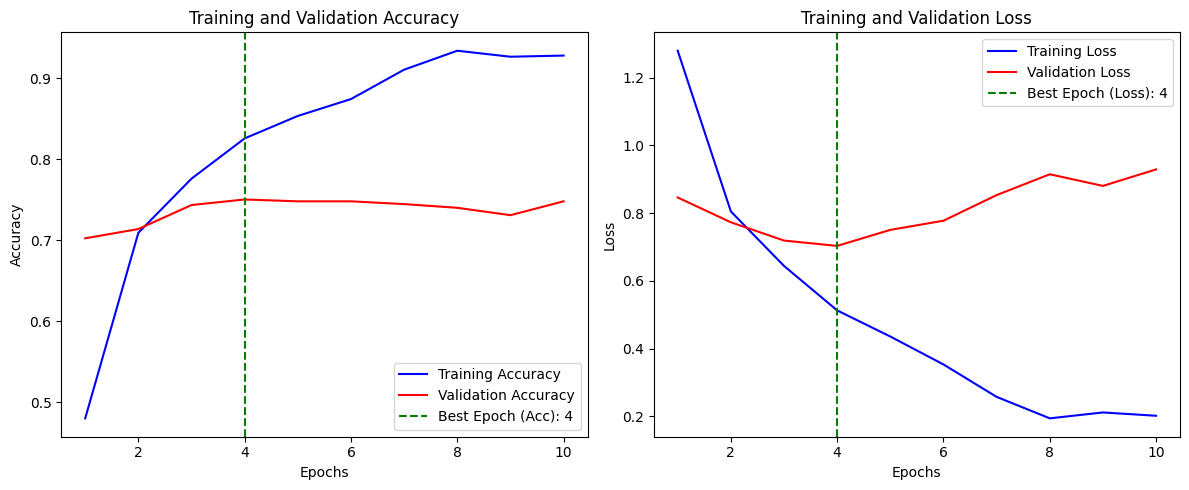

/tmp/ipykernel_29/2873953069.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row_df], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 22s 493ms/step

Epoch 1 - Precision: 0.7658, Recall: 0.7570, F1-Score: 0.7584
220/220 [==============================] - 214s 855ms/step - loss: 1.2000 - categorical_accuracy: 0.5344 - val_loss: 0.7147 - val_categorical_accuracy: 0.7568 - val_precision: 0.7658 - val_recall: 0.7570 - val_f1_score: 0.7584
Epoch 2/10
28/28 [==============================] - 14s 484ms/step

Epoch 2 - Precision: 0.7740, Recall: 0.7536, F1-Score: 0.7541
220/220 [==============================] - 170s 775ms/step - loss: 0.6727 - categorical_accuracy: 0.7609 - val_loss: 0.7062 - val_categorical_accuracy: 0.7534 - val_precision: 0.7740 - val_recall: 0.7536 - val_f1_score: 0.7541
Epoch 3/10
28/28 [==============================] - 14s 485ms/step

Epoch 3 - Precision: 0.7788, Recall: 0.7430, F1-Score: 0.7483
220/220 [==============================] - 170s 772ms/step - loss: 0.4752 - categorical_accuracy: 0.8351 - val_loss: 0.7990 - val_categorical_accura

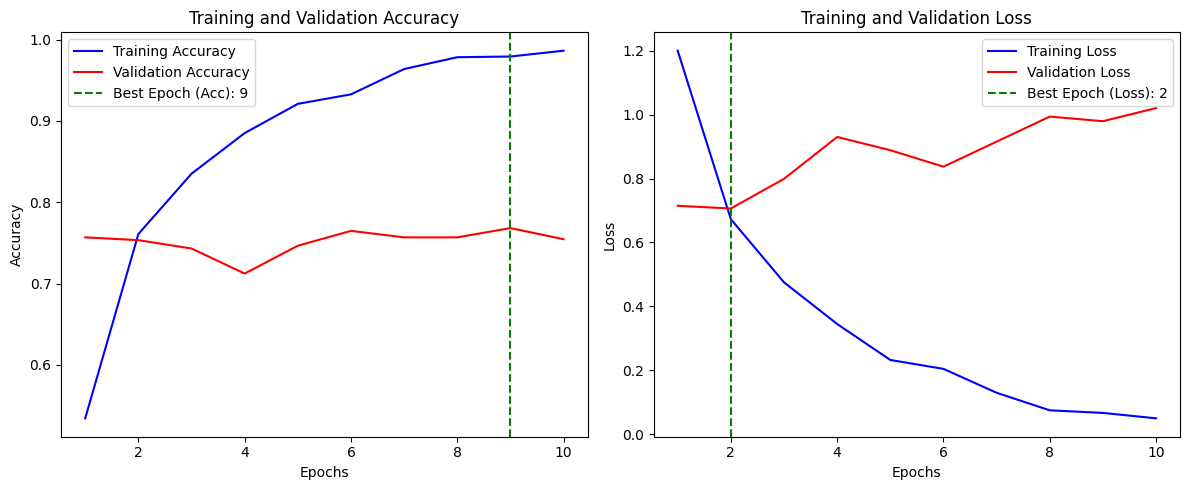


Fold 3
Epoch 1/10
28/28 [==============================] - 22s 490ms/step

Epoch 1 - Precision: 0.7524, Recall: 0.7328, F1-Score: 0.7367
220/220 [==============================] - 217s 854ms/step - loss: 1.2533 - categorical_accuracy: 0.4719 - val_loss: 0.7744 - val_categorical_accuracy: 0.7329 - val_precision: 0.7524 - val_recall: 0.7328 - val_f1_score: 0.7367
Epoch 2/10
28/28 [==============================] - 14s 485ms/step

Epoch 2 - Precision: 0.7717, Recall: 0.7489, F1-Score: 0.7541
220/220 [==============================] - 170s 775ms/step - loss: 0.7092 - categorical_accuracy: 0.7424 - val_loss: 0.7041 - val_categorical_accuracy: 0.7489 - val_precision: 0.7717 - val_recall: 0.7489 - val_f1_score: 0.7541
Epoch 3/10
28/28 [==============================] - 14s 483ms/step

Epoch 3 - Precision: 0.7639, Recall: 0.7386, F1-Score: 0.7449
220/220 [==============================] - 170s 773ms/step - loss: 0.5242 - categorical_accuracy: 0.8151 - val_loss: 0.7239 - val_categorical_accura

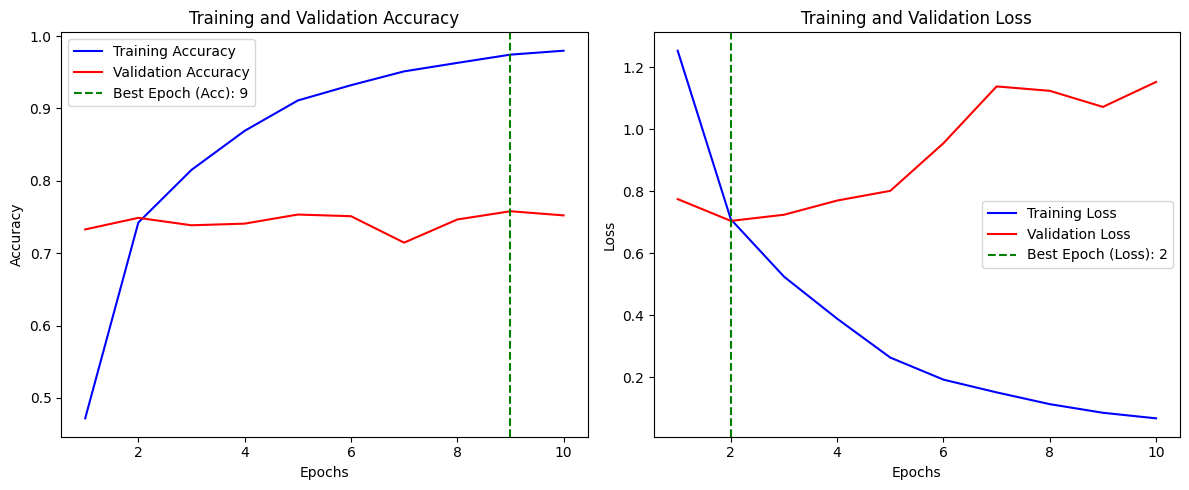


Fold 4
Epoch 1/10
28/28 [==============================] - 22s 481ms/step

Epoch 1 - Precision: 0.0400, Recall: 0.2000, F1-Score: 0.0666
220/220 [==============================] - 215s 850ms/step - loss: 1.2576 - categorical_accuracy: 0.4716 - val_loss: 1.6927 - val_categorical_accuracy: 0.1998 - val_precision: 0.0400 - val_recall: 0.2000 - val_f1_score: 0.0666
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 14s 483ms/step

Epoch 2 - Precision: 0.5652, Recall: 0.5388, F1-Score: 0.5088
220/220 [==============================] - 169s 771ms/step - loss: 1.5761 - categorical_accuracy: 0.2668 - val_loss: 1.1805 - val_categorical_accuracy: 0.5388 - val_precision: 0.5652 - val_recall: 0.5388 - val_f1_score: 0.5088
Epoch 3/10
28/28 [==============================] - 14s 482ms/step

Epoch 3 - Precision: 0.7427, Recall: 0.7113, F1-Score: 0.7140
220/220 [==============================] - 169s 771ms/step - loss: 0.9084 - categorical_accuracy: 0.6668 - val_loss: 0.7976 - val_categorical_accuracy: 0.7112 - val_precision: 0.7427 - val_recall: 0.7113 - val_f1_score: 0.7140
Epoch 4/10
28/28 [==============================] - 14s 484ms/step

Epoch 4 - Precision: 0.7587, Recall: 0.7352, F1-Score: 0.7353
220/220 [==============================] - 169s 771ms/step - loss: 0.6822 - categorical_accuracy: 0.7732 - val_loss: 0.7578 - val_categorical_accuracy: 0.7352 - val_pr

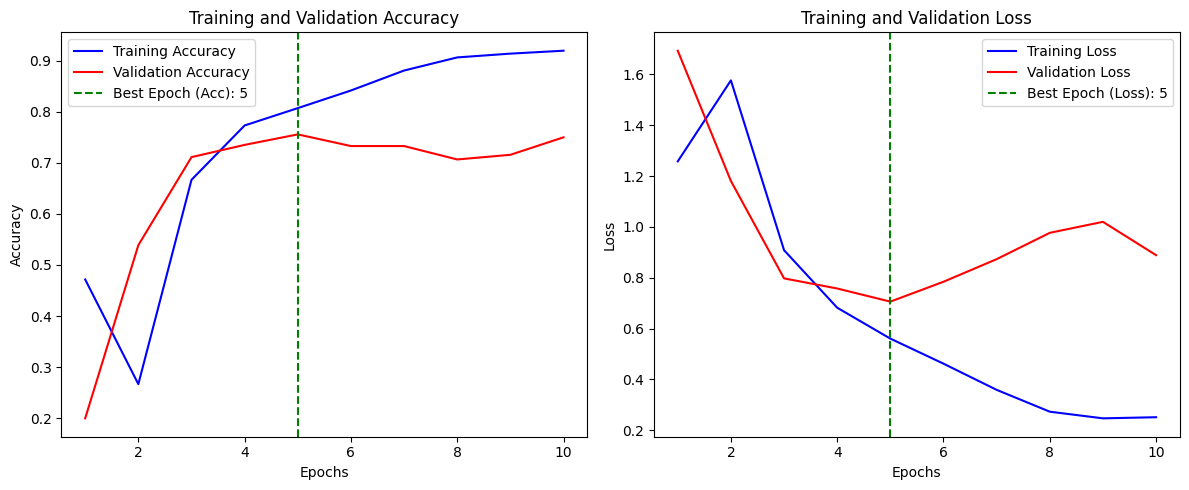


Fold 5
Epoch 1/10
28/28 [==============================] - 22s 491ms/step

Epoch 1 - Precision: 0.7463, Recall: 0.7008, F1-Score: 0.7049
220/220 [==============================] - 214s 852ms/step - loss: 1.2715 - categorical_accuracy: 0.4713 - val_loss: 0.8663 - val_categorical_accuracy: 0.7009 - val_precision: 0.7463 - val_recall: 0.7008 - val_f1_score: 0.7049
Epoch 2/10
28/28 [==============================] - 14s 487ms/step

Epoch 2 - Precision: 0.7748, Recall: 0.7614, F1-Score: 0.7618
220/220 [==============================] - 170s 775ms/step - loss: 0.7274 - categorical_accuracy: 0.7347 - val_loss: 0.6549 - val_categorical_accuracy: 0.7614 - val_precision: 0.7748 - val_recall: 0.7614 - val_f1_score: 0.7618
Epoch 3/10
28/28 [==============================] - 13s 482ms/step

Epoch 3 - Precision: 0.7822, Recall: 0.7705, F1-Score: 0.7691
220/220 [==============================] - 170s 772ms/step - loss: 0.5556 - categorical_accuracy: 0.8026 - val_loss: 0.6781 - val_categorical_accura

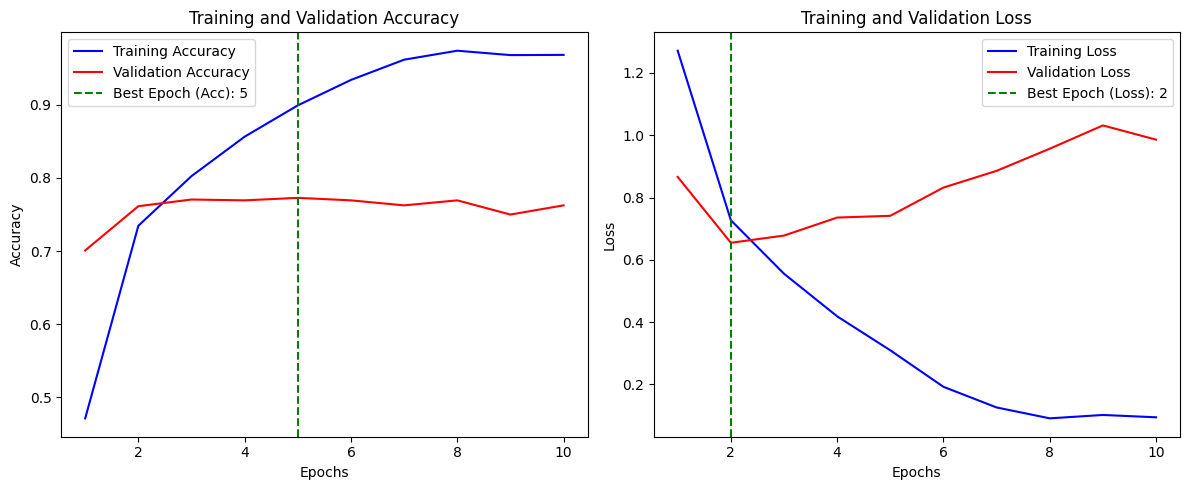

Training Accuracy: 0.8324
Training Loss: 0.4511
Validation Accuracy: 0.7298
Validation Loss: 0.8838
Macro F1: 0.7268
Macro Precision: 0.7390
Macro Recall: 0.7298
Results saved to /kaggle/working/results_albert_isear.csv


In [65]:
csv_filename = '/kaggle/working/results_albert_isear_raw.csv'

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=train_x_raw,
    train_y=train_y_raw,
    train_y_ohe=train_y_ohe_raw,
    model_name='albert',
    dataset='ISEAR',
    dataset_type='raw',
    batch_size=16
)

In [66]:
isear_albert_raw_result = pd.read_csv(csv_filename)
isear_albert_raw_result

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.480308,1.279419,0.702395,0.846030,0.705410,0.728960,0.702474
1,16,1,2,0.709189,0.804860,0.713797,0.772825,0.715446,0.737151,0.713831
2,16,1,3,0.775970,0.643955,0.743444,0.718857,0.742947,0.750454,0.743519
3,16,1,4,0.825628,0.512627,0.750285,0.703079,0.750392,0.759473,0.750422
4,16,1,5,0.853311,0.435469,0.748005,0.750374,0.748460,0.751198,0.748143
5,16,1,6,0.874144,0.353003,0.748005,0.777425,0.744487,0.748028,0.748201
6,16,1,7,0.910388,0.257304,0.744584,0.853052,0.743300,0.752306,0.744740
7,16,1,8,0.933790,0.193889,0.740023,0.914589,0.738497,0.744776,0.740253
8,16,1,9,0.926370,0.211285,0.730901,0.880232,0.731245,0.735034,0.731123
9,16,1,10,0.927797,0.201514,0.748005,0.928941,0.746124,0.753000,0.748273


# Train Test Split Go Emotions

## Preprocessed GOE

In [45]:
goe_df_x = goe_df['comment_text']
goe_df_y = goe_df['Label']

In [46]:
goe_train_x, goe_val_x, goe_train_y, goe_val_y = train_test_split(goe_df_x,goe_df_y , test_size = .2, random_state = 101, stratify = goe_df_y)
goe_val_x, goe_test_x, goe_val_y, goe_test_y = train_test_split(goe_val_x, goe_val_y, test_size = .5, random_state = 101, stratify = goe_val_y)

## Raw GOE

In [47]:
goe_df_x_raw = goe_df_raw['comment_text']
goe_df_y_raw = goe_df_raw['Label']

In [48]:
goe_train_x_raw, goe_val_x_raw, goe_train_y_raw, goe_val_y_raw = train_test_split(goe_df_x_raw,goe_df_y_raw , test_size = .2, random_state = 101,stratify = goe_df_y_raw)
goe_val_x_raw, goe_test_x_raw, goe_val_y_raw, goe_test_y_raw = train_test_split(goe_val_x_raw, goe_val_y_raw, test_size = .5, random_state = 101,stratify = goe_val_y_raw)

## One Hot Encoding Preprocessed GOE

In [49]:
ohe2 = preprocessing.OneHotEncoder()

goe_train_y_ohe  = ohe2.fit_transform(np.array(goe_train_y).reshape(-1, 1)).toarray()
goe_val_y_ohe  = ohe2.fit_transform(np.array(goe_val_y).reshape(-1, 1)).toarray()
goe_test_y_ohe  = ohe2.fit_transform(np.array(goe_test_y).reshape(-1, 1)).toarray()

goe_train_x = goe_train_x.reset_index(drop = True)
goe_val_x = goe_val_x.reset_index(drop = True)
goe_test_x = goe_test_x.reset_index(drop = True)

## One Hot Encoding Raw GOE

In [50]:
goe_train_y_ohe_raw  = ohe2.fit_transform(np.array(goe_train_y_raw).reshape(-1, 1)).toarray()
goe_val_y_ohe_raw  = ohe2.fit_transform(np.array(goe_val_y_raw).reshape(-1, 1)).toarray()
goe_test_y_ohe_raw  = ohe2.fit_transform(np.array(goe_test_y_raw).reshape(-1, 1)).toarray()

goe_train_x_raw = goe_train_x_raw.reset_index(drop = True)
goe_val_x_raw = goe_val_x_raw.reset_index(drop = True)
goe_test_x_raw = goe_test_x_raw.reset_index(drop = True)

## Training on Go Emotion Preprocessed

### Roberta

In [51]:
csv_columns = ['Batch Size','Fold', 'Epoch', 'Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 
               'Macro F1', 'Macro Precision', 'Macro Recall']


Fold 1
Epoch 1/10


I0000 00:00:1728654429.285793     113 service.cc:145] XLA service 0x79f9a39bf170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728654429.285845     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728654429.285849     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728654429.499731     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 15s 91ms/step

Epoch 1 - Precision: 0.7811, Recall: 0.7752, F1-Score: 0.7718
217/217 [==============================] - 140s 292ms/step - loss: 1.2967 - categorical_accuracy: 0.4948 - val_loss: 0.6599 - val_categorical_accuracy: 0.7829 - val_precision: 0.7811 - val_recall: 0.7752 - val_f1_score: 0.7718
Epoch 2/10
28/28 [==============================] - 3s 92ms/step

Epoch 2 - Precision: 0.8339, Recall: 0.8091, F1-Score: 0.8179
217/217 [==============================] - 39s 178ms/step - loss: 0.5763 - categorical_accuracy: 0.8059 - val_loss: 0.5957 - val_categorical_accuracy: 0.8222 - val_precision: 0.8339 - val_recall: 0.8091 - val_f1_score: 0.8179
Epoch 3/10
28/28 [==============================] - 3s 94ms/step

Epoch 3 - Precision: 0.8401, Recall: 0.8049, F1-Score: 0.8150
217/217 [==============================] - 40s 184ms/step - loss: 0.4084 - categorical_accuracy: 0.8668 - val_loss: 0.6360 - val_categorical_accuracy: 0.8199 - val_precision

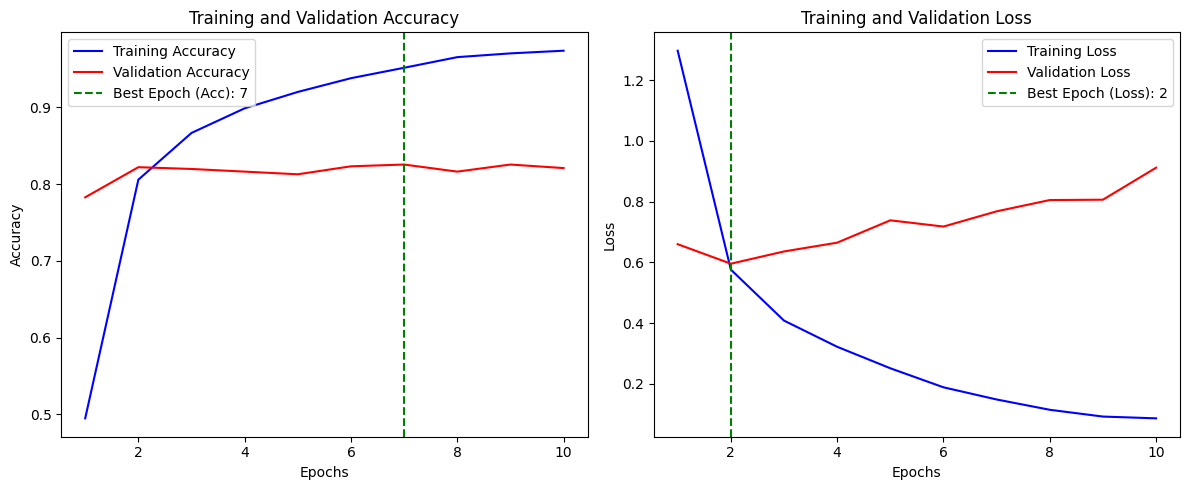

/tmp/ipykernel_30/3166976722.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 14s 94ms/step

Epoch 1 - Precision: 0.7984, Recall: 0.7870, F1-Score: 0.7896
217/217 [==============================] - 124s 302ms/step - loss: 1.2314 - categorical_accuracy: 0.5188 - val_loss: 0.5681 - val_categorical_accuracy: 0.8002 - val_precision: 0.7984 - val_recall: 0.7870 - val_f1_score: 0.7896
Epoch 2/10
28/28 [==============================] - 3s 95ms/step

Epoch 2 - Precision: 0.8439, Recall: 0.8154, F1-Score: 0.8242
217/217 [==============================] - 40s 185ms/step - loss: 0.5673 - categorical_accuracy: 0.8177 - val_loss: 0.5260 - val_categorical_accuracy: 0.8337 - val_precision: 0.8439 - val_recall: 0.8154 - val_f1_score: 0.8242
Epoch 3/10
28/28 [==============================] - 3s 92ms/step

Epoch 3 - Precision: 0.8412, Recall: 0.8034, F1-Score: 0.8109
217/217 [==============================] - 39s 182ms/step - loss: 0.4287 - categorical_accuracy: 0.8666 - val_loss: 0.5479 - val_categorical_accuracy: 0.8

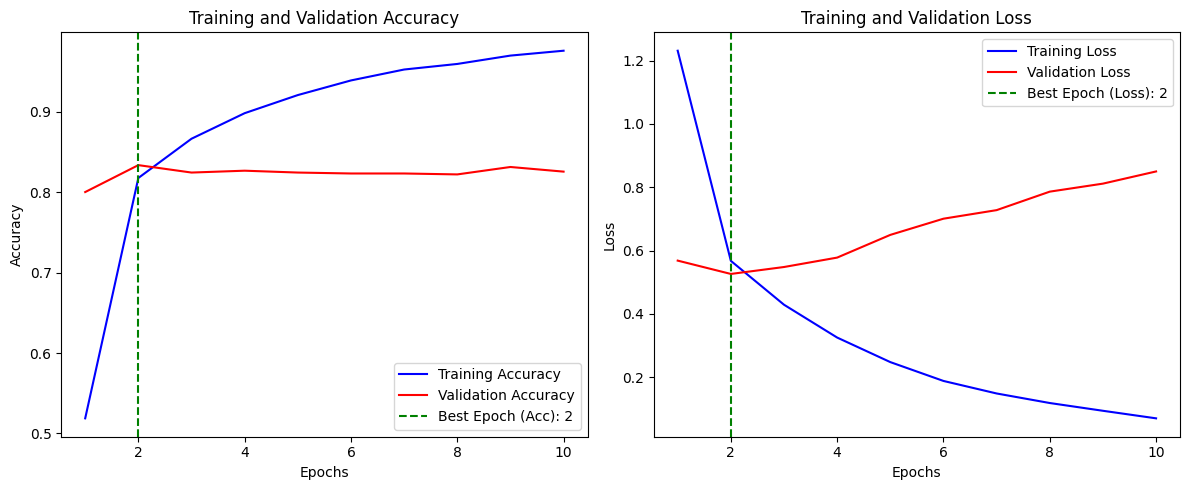


Fold 3
Epoch 1/10
28/28 [==============================] - 15s 95ms/step

Epoch 1 - Precision: 0.8028, Recall: 0.7899, F1-Score: 0.7939
217/217 [==============================] - 125s 309ms/step - loss: 1.3166 - categorical_accuracy: 0.4772 - val_loss: 0.5917 - val_categorical_accuracy: 0.8072 - val_precision: 0.8028 - val_recall: 0.7899 - val_f1_score: 0.7939
Epoch 2/10
28/28 [==============================] - 3s 93ms/step

Epoch 2 - Precision: 0.8359, Recall: 0.8084, F1-Score: 0.8176
217/217 [==============================] - 40s 185ms/step - loss: 0.5889 - categorical_accuracy: 0.8047 - val_loss: 0.5375 - val_categorical_accuracy: 0.8256 - val_precision: 0.8359 - val_recall: 0.8084 - val_f1_score: 0.8176
Epoch 3/10
28/28 [==============================] - 3s 94ms/step

Epoch 3 - Precision: 0.8424, Recall: 0.8209, F1-Score: 0.8296
217/217 [==============================] - 40s 182ms/step - loss: 0.4385 - categorical_accuracy: 0.8564 - val_loss: 0.5322 - val_categorical_accuracy: 0.8

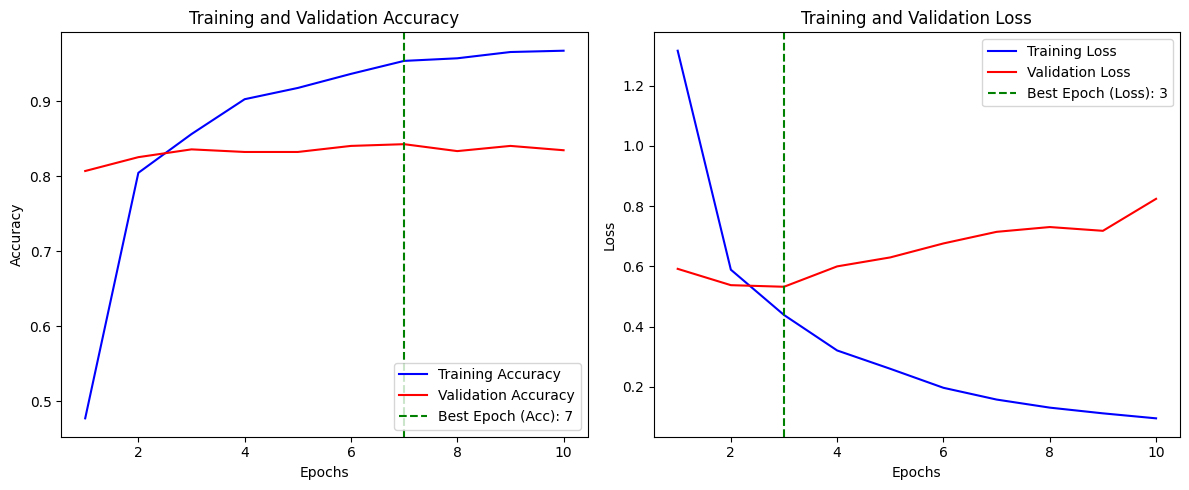


Fold 4
Epoch 1/10
28/28 [==============================] - 14s 93ms/step

Epoch 1 - Precision: 0.7919, Recall: 0.7725, F1-Score: 0.7785
217/217 [==============================] - 124s 307ms/step - loss: 1.1931 - categorical_accuracy: 0.5348 - val_loss: 0.6339 - val_categorical_accuracy: 0.7942 - val_precision: 0.7919 - val_recall: 0.7725 - val_f1_score: 0.7785
Epoch 2/10
28/28 [==============================] - 3s 93ms/step

Epoch 2 - Precision: 0.8400, Recall: 0.8048, F1-Score: 0.8161
217/217 [==============================] - 40s 185ms/step - loss: 0.5482 - categorical_accuracy: 0.8236 - val_loss: 0.6059 - val_categorical_accuracy: 0.8266 - val_precision: 0.8400 - val_recall: 0.8048 - val_f1_score: 0.8161
Epoch 3/10
28/28 [==============================] - 3s 92ms/step

Epoch 3 - Precision: 0.8461, Recall: 0.8090, F1-Score: 0.8206
217/217 [==============================] - 39s 182ms/step - loss: 0.4108 - categorical_accuracy: 0.8692 - val_loss: 0.6445 - val_categorical_accuracy: 0.8

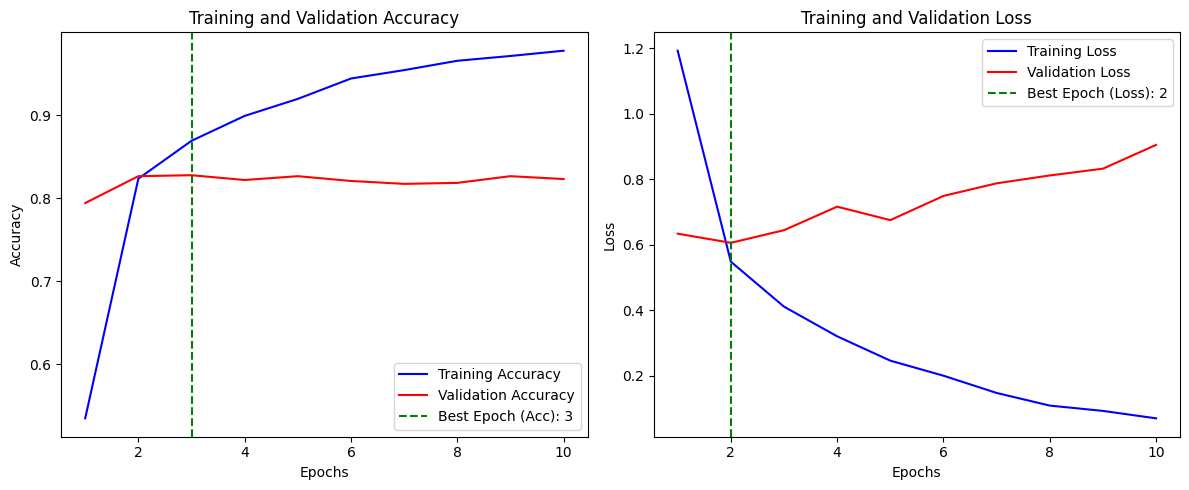


Fold 5
Epoch 1/10
28/28 [==============================] - 17s 94ms/step

Epoch 1 - Precision: 0.7791, Recall: 0.7658, F1-Score: 0.7682
217/217 [==============================] - 125s 311ms/step - loss: 1.1688 - categorical_accuracy: 0.5463 - val_loss: 0.6723 - val_categorical_accuracy: 0.7780 - val_precision: 0.7791 - val_recall: 0.7658 - val_f1_score: 0.7682
Epoch 2/10
28/28 [==============================] - 3s 94ms/step

Epoch 2 - Precision: 0.7940, Recall: 0.8035, F1-Score: 0.7959
217/217 [==============================] - 40s 186ms/step - loss: 0.5551 - categorical_accuracy: 0.8189 - val_loss: 0.6102 - val_categorical_accuracy: 0.8035 - val_precision: 0.7940 - val_recall: 0.8035 - val_f1_score: 0.7959
Epoch 3/10
28/28 [==============================] - 3s 92ms/step

Epoch 3 - Precision: 0.7950, Recall: 0.8031, F1-Score: 0.7979
217/217 [==============================] - 40s 183ms/step - loss: 0.4093 - categorical_accuracy: 0.8672 - val_loss: 0.6438 - val_categorical_accuracy: 0.8

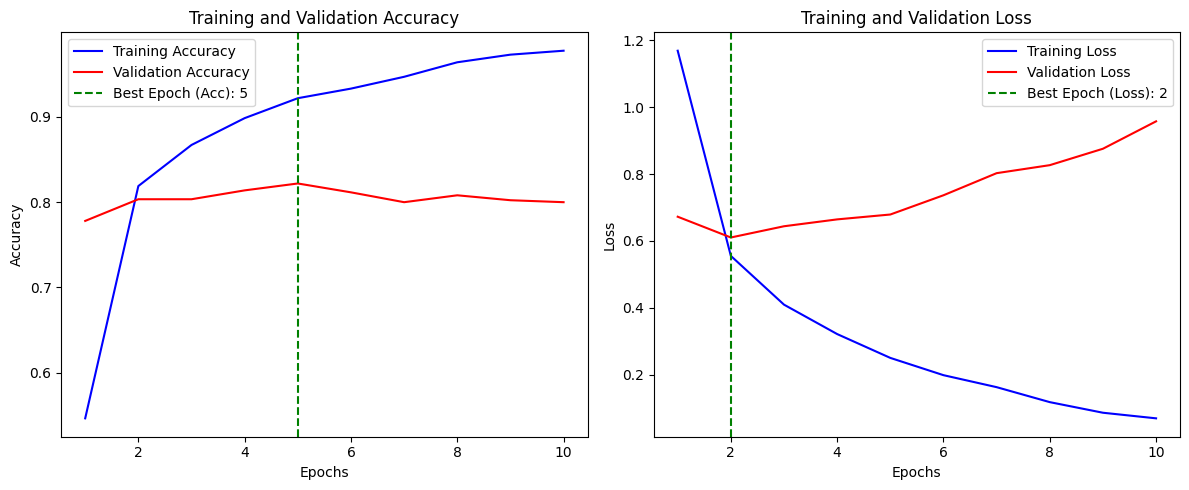


Average Results :
Training Accuracy: 0.8811
Training Loss: 0.3439
Validation Accuracy: 0.8195
Validation Loss: 0.7087
Macro F1: 0.8098
Macro Precision: 0.8243
Macro Recall: 0.8043
Results saved to /kaggle/working/results_roberta_goe.csv


In [52]:
csv_filename = '/kaggle/working/results_roberta_goe.csv'

training_func_kfold(
    k = 5,
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=goe_train_x,
    train_y=goe_train_y,
    train_y_ohe=goe_train_y_ohe,
    model_name='roberta',
    dataset='GOE',
    dataset_type='preprocess',
    batch_size=16
)

In [53]:
test_df = pd.read_csv('/kaggle/working/results_roberta_goe.csv')
test_df

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.494801,1.296737,0.782910,0.659876,0.771807,0.781138,0.775154
1,16,1,2,0.805893,0.576254,0.822171,0.595679,0.817908,0.833922,0.809117
2,16,1,3,0.866840,0.408403,0.819861,0.636004,0.814960,0.840118,0.804866
3,16,1,4,0.898902,0.322230,0.816397,0.664925,0.811300,0.840334,0.800999
4,16,1,5,0.920277,0.251492,0.812933,0.738491,0.804180,0.839496,0.790767
5,16,1,6,0.938186,0.188839,0.823326,0.717921,0.813537,0.827449,0.806784
6,16,1,7,0.951762,0.148785,0.825635,0.768071,0.818440,0.829550,0.813119
7,16,1,8,0.965627,0.114853,0.816397,0.805184,0.808210,0.821763,0.801484
8,16,1,9,0.970537,0.092540,0.825635,0.806369,0.816580,0.818250,0.815618
9,16,1,10,0.974003,0.086704,0.821016,0.911673,0.808958,0.833699,0.798497


### ALBERT


Fold 1
Epoch 1/10
28/28 [==============================] - 11s 98ms/step

Epoch 1 - Precision: 0.7088, Recall: 0.5799, F1-Score: 0.5659
217/217 [==============================] - 81s 247ms/step - loss: 1.5604 - categorical_accuracy: 0.3865 - val_loss: 1.0463 - val_categorical_accuracy: 0.6316 - val_precision: 0.7088 - val_recall: 0.5799 - val_f1_score: 0.5659
Epoch 2/10
28/28 [==============================] - 3s 96ms/step

Epoch 2 - Precision: 0.7935, Recall: 0.7837, F1-Score: 0.7860
217/217 [==============================] - 36s 167ms/step - loss: 0.7748 - categorical_accuracy: 0.7501 - val_loss: 0.6678 - val_categorical_accuracy: 0.7968 - val_precision: 0.7935 - val_recall: 0.7837 - val_f1_score: 0.7860
Epoch 3/10
28/28 [==============================] - 3s 96ms/step

Epoch 3 - Precision: 0.8153, Recall: 0.7915, F1-Score: 0.7965
217/217 [==============================] - 36s 164ms/step - loss: 0.5182 - categorical_accuracy: 0.8316 - val_loss: 0.6585 - val_categorical_accuracy: 0.80

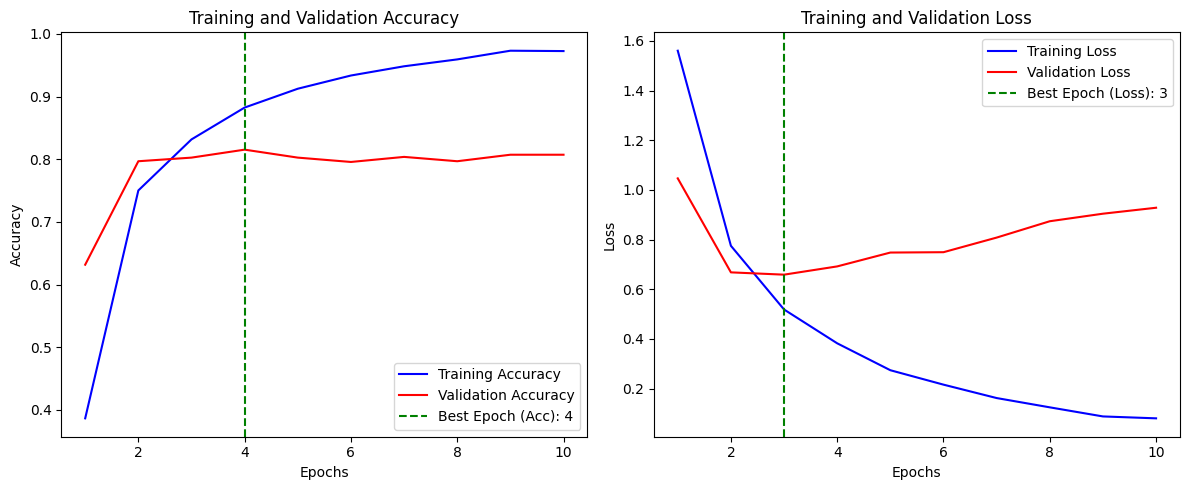

/tmp/ipykernel_29/3166976722.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 12s 97ms/step

Epoch 1 - Precision: 0.0389, Recall: 0.1667, F1-Score: 0.0630
217/217 [==============================] - 83s 259ms/step - loss: 1.8167 - categorical_accuracy: 0.2060 - val_loss: 1.7371 - val_categorical_accuracy: 0.2333 - val_precision: 0.0389 - val_recall: 0.1667 - val_f1_score: 0.0630
Epoch 2/10
  1/217 [..............................] - ETA: 28s - loss: 1.8862 - categorical_accuracy: 0.2500

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 3s 97ms/step

Epoch 2 - Precision: 0.7329, Recall: 0.6573, F1-Score: 0.6596
217/217 [==============================] - 36s 167ms/step - loss: 1.2976 - categorical_accuracy: 0.4980 - val_loss: 0.9122 - val_categorical_accuracy: 0.6836 - val_precision: 0.7329 - val_recall: 0.6573 - val_f1_score: 0.6596
Epoch 3/10
28/28 [==============================] - 3s 95ms/step

Epoch 3 - Precision: 0.8140, Recall: 0.7830, F1-Score: 0.7911
217/217 [==============================] - 36s 164ms/step - loss: 0.6884 - categorical_accuracy: 0.7718 - val_loss: 0.6062 - val_categorical_accuracy: 0.8048 - val_precision: 0.8140 - val_recall: 0.7830 - val_f1_score: 0.7911
Epoch 4/10
28/28 [==============================] - 3s 96ms/step

Epoch 4 - Precision: 0.8170, Recall: 0.7811, F1-Score: 0.7850
217/217 [==============================] - 36s 165ms/step - loss: 0.4976 - categorical_accuracy: 0.8469 - val_loss: 0.6527 - val_categorical_accuracy: 0.7956 - val_precision: 

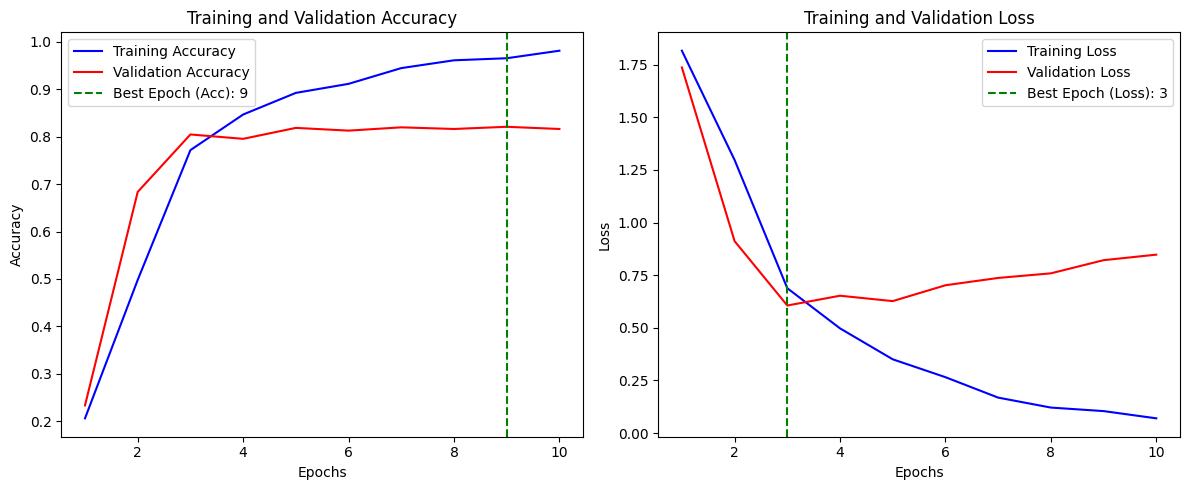


Fold 3
Epoch 1/10
28/28 [==============================] - 11s 97ms/step

Epoch 1 - Precision: 0.6419, Recall: 0.5738, F1-Score: 0.5525
217/217 [==============================] - 79s 244ms/step - loss: 1.6073 - categorical_accuracy: 0.3605 - val_loss: 1.0289 - val_categorical_accuracy: 0.6374 - val_precision: 0.6419 - val_recall: 0.5738 - val_f1_score: 0.5525
Epoch 2/10
28/28 [==============================] - 3s 96ms/step

Epoch 2 - Precision: 0.8046, Recall: 0.7833, F1-Score: 0.7898
217/217 [==============================] - 36s 166ms/step - loss: 0.8152 - categorical_accuracy: 0.7279 - val_loss: 0.5901 - val_categorical_accuracy: 0.8037 - val_precision: 0.8046 - val_recall: 0.7833 - val_f1_score: 0.7898
Epoch 3/10
28/28 [==============================] - 3s 95ms/step

Epoch 3 - Precision: 0.8078, Recall: 0.7940, F1-Score: 0.7976
217/217 [==============================] - 36s 164ms/step - loss: 0.5409 - categorical_accuracy: 0.8212 - val_loss: 0.5815 - val_categorical_accuracy: 0.81

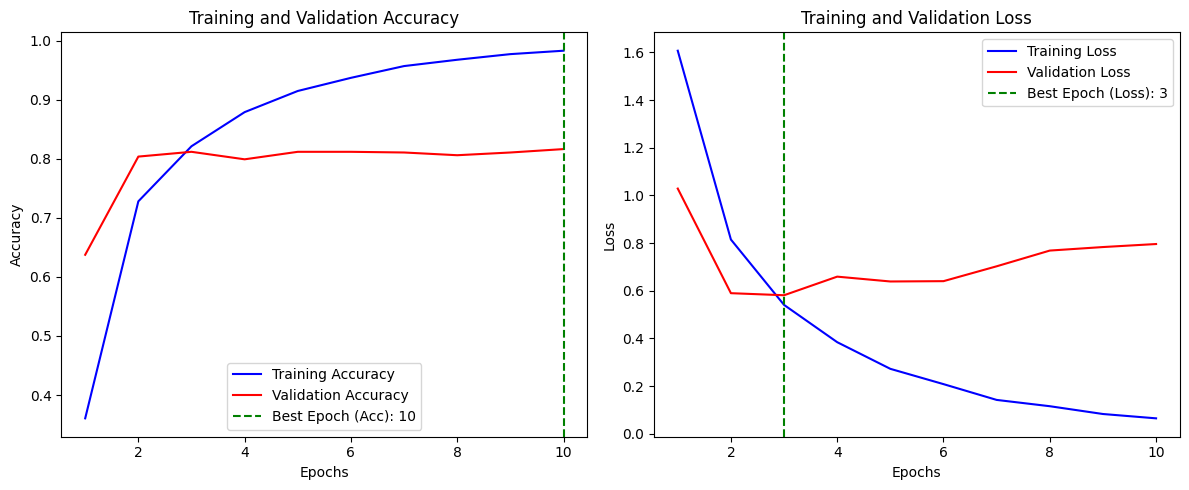


Fold 4
Epoch 1/10
28/28 [==============================] - 12s 96ms/step

Epoch 1 - Precision: 0.4314, Recall: 0.4502, F1-Score: 0.3945
217/217 [==============================] - 84s 251ms/step - loss: 1.6420 - categorical_accuracy: 0.3636 - val_loss: 1.2449 - val_categorical_accuracy: 0.5399 - val_precision: 0.4314 - val_recall: 0.4502 - val_f1_score: 0.3945
Epoch 2/10
  1/217 [..............................] - ETA: 28s - loss: 1.3044 - categorical_accuracy: 0.4375

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 3s 97ms/step

Epoch 2 - Precision: 0.6866, Recall: 0.6264, F1-Score: 0.6240
217/217 [==============================] - 36s 167ms/step - loss: 1.1506 - categorical_accuracy: 0.5787 - val_loss: 0.9140 - val_categorical_accuracy: 0.6855 - val_precision: 0.6866 - val_recall: 0.6264 - val_f1_score: 0.6240
Epoch 3/10
28/28 [==============================] - 3s 95ms/step

Epoch 3 - Precision: 0.7744, Recall: 0.7189, F1-Score: 0.7333
217/217 [==============================] - 36s 164ms/step - loss: 0.7689 - categorical_accuracy: 0.7468 - val_loss: 0.7324 - val_categorical_accuracy: 0.7538 - val_precision: 0.7744 - val_recall: 0.7189 - val_f1_score: 0.7333
Epoch 4/10
28/28 [==============================] - 3s 97ms/step

Epoch 4 - Precision: 0.8002, Recall: 0.7563, F1-Score: 0.7704
217/217 [==============================] - 36s 166ms/step - loss: 0.5544 - categorical_accuracy: 0.8195 - val_loss: 0.6962 - val_categorical_accuracy: 0.7815 - val_precision: 

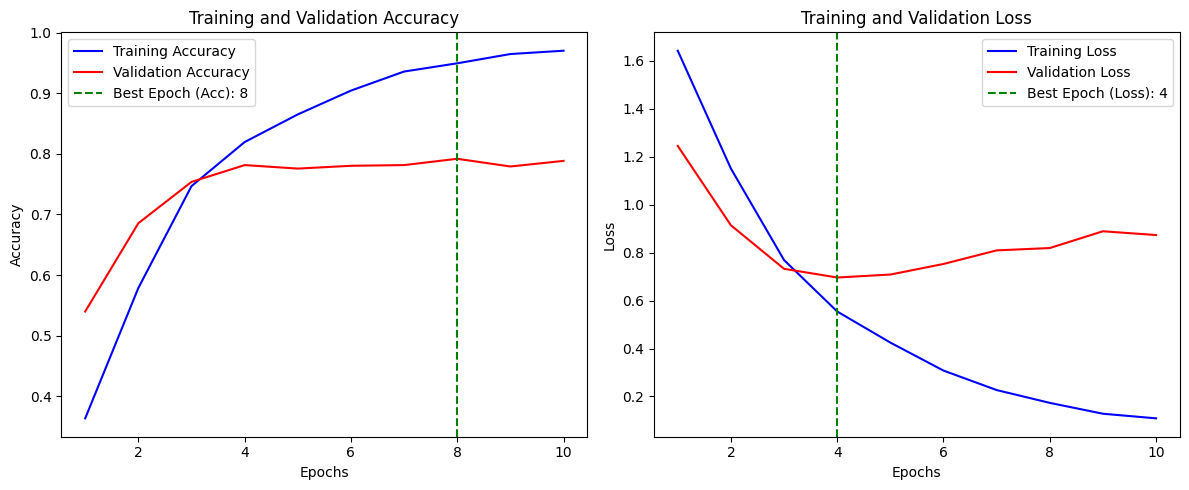


Fold 5
Epoch 1/10
28/28 [==============================] - 11s 97ms/step

Epoch 1 - Precision: 0.2482, Recall: 0.3289, F1-Score: 0.2579
217/217 [==============================] - 81s 246ms/step - loss: 1.8413 - categorical_accuracy: 0.2440 - val_loss: 1.5826 - val_categorical_accuracy: 0.4116 - val_precision: 0.2482 - val_recall: 0.3289 - val_f1_score: 0.2579
Epoch 2/10
  1/217 [..............................] - ETA: 28s - loss: 1.8213 - categorical_accuracy: 0.2500

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 3s 97ms/step

Epoch 2 - Precision: 0.5858, Recall: 0.4778, F1-Score: 0.4440
217/217 [==============================] - 36s 167ms/step - loss: 1.6129 - categorical_accuracy: 0.3581 - val_loss: 1.2156 - val_categorical_accuracy: 0.5607 - val_precision: 0.5858 - val_recall: 0.4778 - val_f1_score: 0.4440
Epoch 3/10
28/28 [==============================] - 3s 96ms/step

Epoch 3 - Precision: 0.7318, Recall: 0.7117, F1-Score: 0.7182
217/217 [==============================] - 36s 164ms/step - loss: 1.0443 - categorical_accuracy: 0.6289 - val_loss: 0.8073 - val_categorical_accuracy: 0.7364 - val_precision: 0.7318 - val_recall: 0.7117 - val_f1_score: 0.7182
Epoch 4/10
28/28 [==============================] - 3s 96ms/step

Epoch 4 - Precision: 0.7859, Recall: 0.7754, F1-Score: 0.7784
217/217 [==============================] - 36s 165ms/step - loss: 0.6802 - categorical_accuracy: 0.7820 - val_loss: 0.6819 - val_categorical_accuracy: 0.7896 - val_precision: 

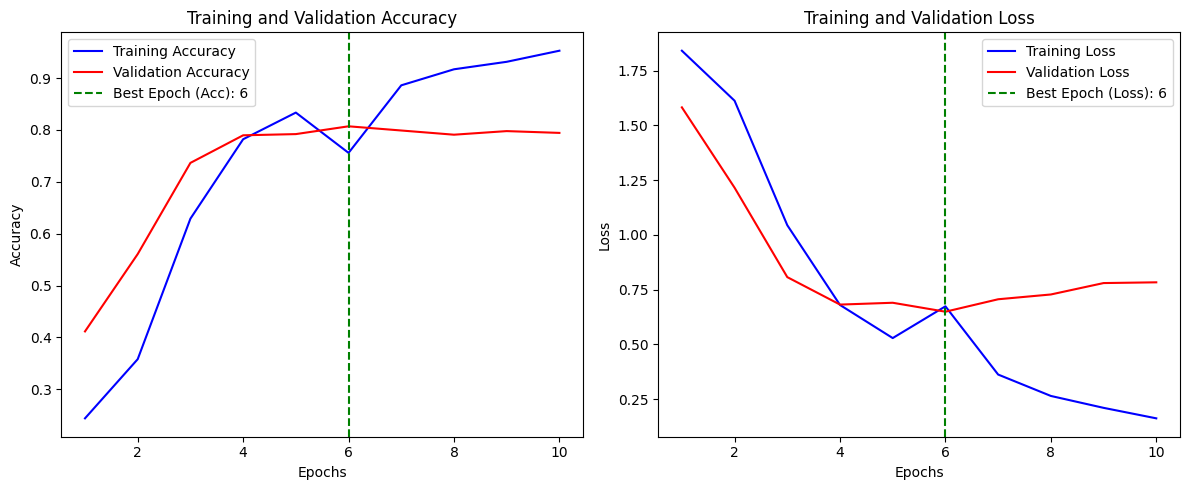


Average Results :
Training Accuracy: 0.8088
Training Loss: 0.5332
Validation Accuracy: 0.7587
Validation Loss: 0.8147
Macro F1: 0.7342
Macro Precision: 0.7545
Macro Recall: 0.7360
Results saved to /kaggle/working/results_albert_goe.csv


In [76]:
csv_filename = '/kaggle/working/results_albert_goe.csv'

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=goe_train_x,
    train_y=goe_train_y,
    train_y_ohe=goe_train_y_ohe,
    model_name='albert',
    dataset='GOE',
    dataset_type='preprocess',
    batch_size=16
)

In [77]:
test_df = pd.read_csv('/kaggle/working/results_albert_goe.csv')
test_df

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.386482,1.560449,0.631640,1.046309,0.565931,0.708754,0.579942
1,16,1,2,0.750144,0.774814,0.796767,0.667790,0.785979,0.793482,0.783744
2,16,1,3,0.831600,0.518239,0.802540,0.658530,0.796460,0.815269,0.791482
3,16,1,4,0.882438,0.382045,0.815242,0.691777,0.813765,0.828138,0.806109
4,16,1,5,0.912478,0.273665,0.802540,0.747577,0.794733,0.809125,0.786647
5,16,1,6,0.933564,0.215577,0.795612,0.748993,0.793251,0.800312,0.791064
6,16,1,7,0.948296,0.161595,0.803695,0.807851,0.797802,0.805435,0.792655
7,16,1,8,0.959272,0.124193,0.796767,0.873683,0.789138,0.808503,0.780502
8,16,1,9,0.973137,0.087566,0.807159,0.904049,0.800700,0.809331,0.795527
9,16,1,10,0.972559,0.079880,0.807159,0.928022,0.801487,0.812375,0.794518


## Training on Go Emotion Raw

### RoBERTa


Fold 1
Epoch 1/10
28/28 [==============================] - 14s 108ms/step

Epoch 1 - Precision: 0.8005, Recall: 0.7813, F1-Score: 0.7859
217/217 [==============================] - 125s 309ms/step - loss: 1.2138 - categorical_accuracy: 0.5257 - val_loss: 0.5644 - val_categorical_accuracy: 0.8014 - val_precision: 0.8005 - val_recall: 0.7813 - val_f1_score: 0.7859
Epoch 2/10
28/28 [==============================] - 3s 108ms/step

Epoch 2 - Precision: 0.8463, Recall: 0.8204, F1-Score: 0.8298
217/217 [==============================] - 45s 206ms/step - loss: 0.4955 - categorical_accuracy: 0.8339 - val_loss: 0.5539 - val_categorical_accuracy: 0.8372 - val_precision: 0.8463 - val_recall: 0.8204 - val_f1_score: 0.8298
Epoch 3/10
28/28 [==============================] - 3s 108ms/step

Epoch 3 - Precision: 0.8557, Recall: 0.8288, F1-Score: 0.8370
217/217 [==============================] - 44s 203ms/step - loss: 0.3596 - categorical_accuracy: 0.8850 - val_loss: 0.5585 - val_categorical_accuracy: 

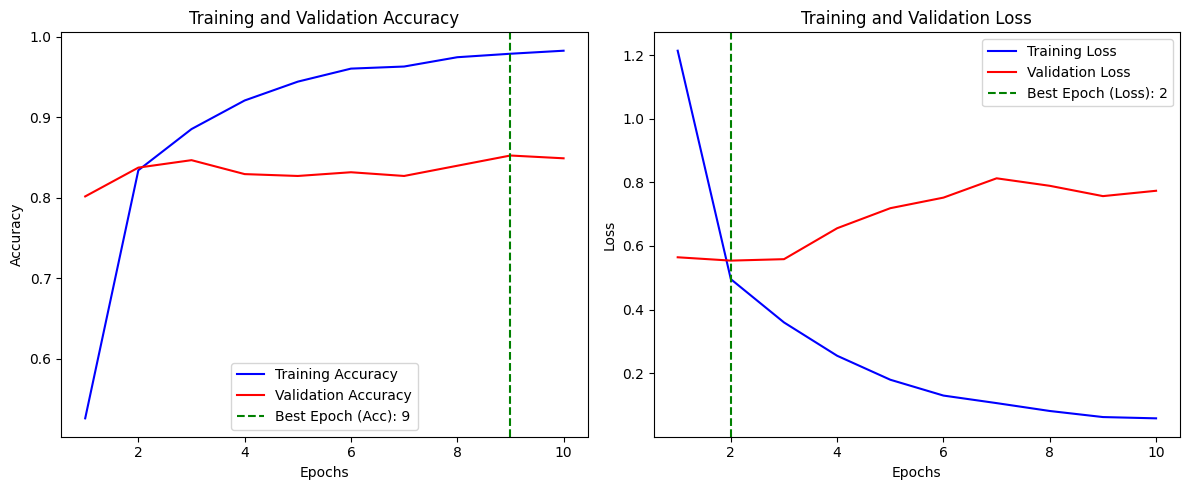

/tmp/ipykernel_29/3166976722.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 13s 107ms/step

Epoch 1 - Precision: 0.8078, Recall: 0.7974, F1-Score: 0.8000
217/217 [==============================] - 118s 304ms/step - loss: 1.2933 - categorical_accuracy: 0.4792 - val_loss: 0.5274 - val_categorical_accuracy: 0.8187 - val_precision: 0.8078 - val_recall: 0.7974 - val_f1_score: 0.8000
Epoch 2/10
28/28 [==============================] - 3s 108ms/step

Epoch 2 - Precision: 0.8403, Recall: 0.8201, F1-Score: 0.8260
217/217 [==============================] - 44s 205ms/step - loss: 0.5423 - categorical_accuracy: 0.8261 - val_loss: 0.4958 - val_categorical_accuracy: 0.8383 - val_precision: 0.8403 - val_recall: 0.8201 - val_f1_score: 0.8260
Epoch 3/10
28/28 [==============================] - 3s 108ms/step

Epoch 3 - Precision: 0.8469, Recall: 0.8144, F1-Score: 0.8239
217/217 [==============================] - 44s 202ms/step - loss: 0.3518 - categorical_accuracy: 0.8807 - val_loss: 0.5281 - val_categorical_accuracy: 

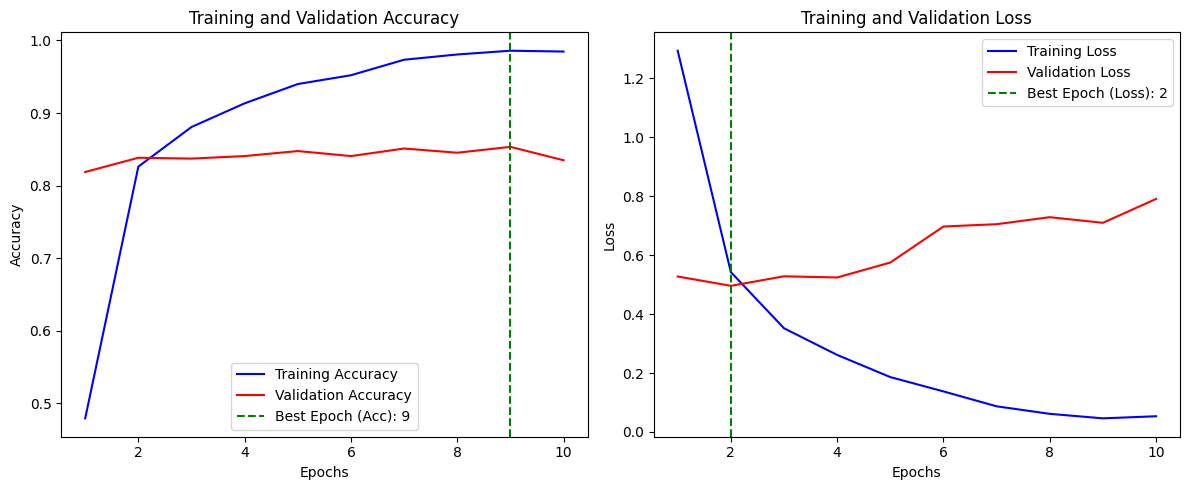


Fold 3
Epoch 1/10
28/28 [==============================] - 14s 108ms/step

Epoch 1 - Precision: 0.8032, Recall: 0.7901, F1-Score: 0.7944
217/217 [==============================] - 123s 306ms/step - loss: 1.3343 - categorical_accuracy: 0.4685 - val_loss: 0.5336 - val_categorical_accuracy: 0.8106 - val_precision: 0.8032 - val_recall: 0.7901 - val_f1_score: 0.7944
Epoch 2/10
28/28 [==============================] - 3s 108ms/step

Epoch 2 - Precision: 0.8527, Recall: 0.8434, F1-Score: 0.8461
217/217 [==============================] - 45s 206ms/step - loss: 0.5090 - categorical_accuracy: 0.8264 - val_loss: 0.4702 - val_categorical_accuracy: 0.8545 - val_precision: 0.8527 - val_recall: 0.8434 - val_f1_score: 0.8461
Epoch 3/10
28/28 [==============================] - 3s 108ms/step

Epoch 3 - Precision: 0.8607, Recall: 0.8422, F1-Score: 0.8481
217/217 [==============================] - 44s 202ms/step - loss: 0.3479 - categorical_accuracy: 0.8888 - val_loss: 0.4902 - val_categorical_accuracy: 

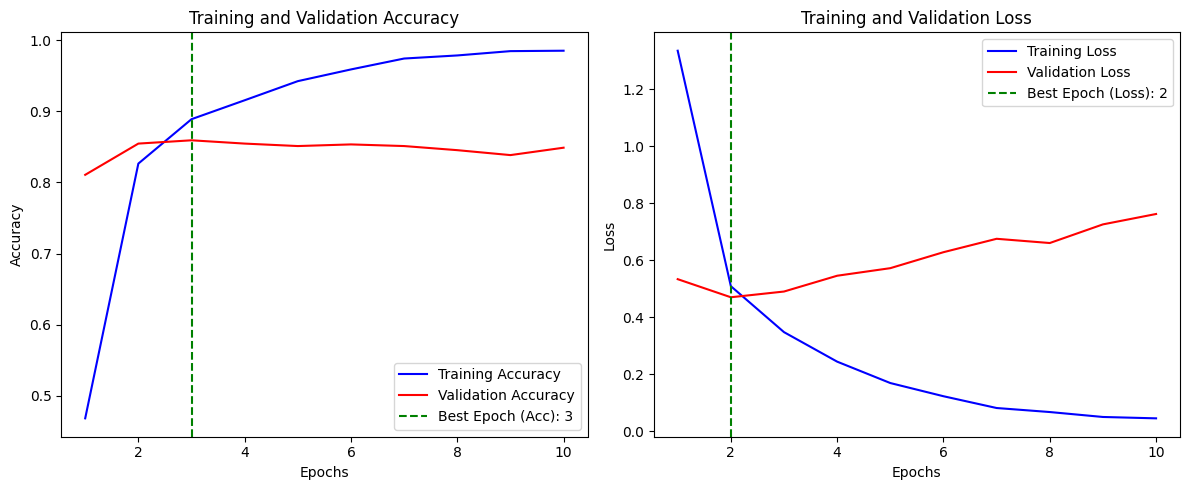


Fold 4
Epoch 1/10
28/28 [==============================] - 13s 108ms/step

Epoch 1 - Precision: 0.8122, Recall: 0.7965, F1-Score: 0.8004
217/217 [==============================] - 121s 304ms/step - loss: 1.1545 - categorical_accuracy: 0.5513 - val_loss: 0.5726 - val_categorical_accuracy: 0.8139 - val_precision: 0.8122 - val_recall: 0.7965 - val_f1_score: 0.8004
Epoch 2/10
28/28 [==============================] - 3s 108ms/step

Epoch 2 - Precision: 0.8302, Recall: 0.8050, F1-Score: 0.8123
217/217 [==============================] - 44s 205ms/step - loss: 0.4747 - categorical_accuracy: 0.8444 - val_loss: 0.5470 - val_categorical_accuracy: 0.8243 - val_precision: 0.8302 - val_recall: 0.8050 - val_f1_score: 0.8123
Epoch 3/10
28/28 [==============================] - 3s 107ms/step

Epoch 3 - Precision: 0.8340, Recall: 0.8020, F1-Score: 0.8112
217/217 [==============================] - 44s 202ms/step - loss: 0.3123 - categorical_accuracy: 0.8966 - val_loss: 0.6070 - val_categorical_accuracy: 

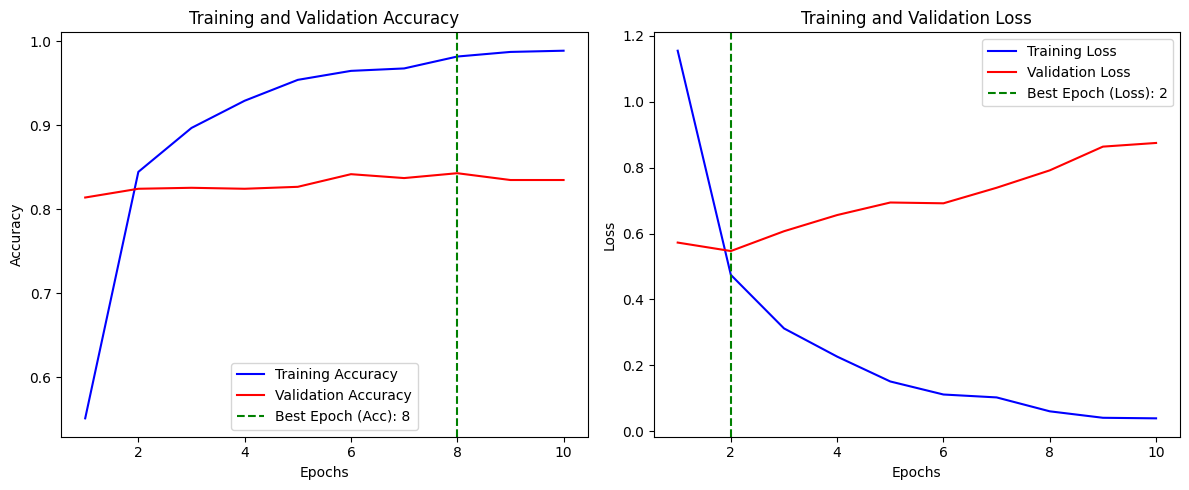


Fold 5
Epoch 1/10
28/28 [==============================] - 14s 107ms/step

Epoch 1 - Precision: 0.7782, Recall: 0.7622, F1-Score: 0.7634
217/217 [==============================] - 123s 308ms/step - loss: 1.2067 - categorical_accuracy: 0.5149 - val_loss: 0.6772 - val_categorical_accuracy: 0.7711 - val_precision: 0.7782 - val_recall: 0.7622 - val_f1_score: 0.7634
Epoch 2/10
28/28 [==============================] - 3s 108ms/step

Epoch 2 - Precision: 0.8081, Recall: 0.8062, F1-Score: 0.8059
217/217 [==============================] - 45s 205ms/step - loss: 0.4886 - categorical_accuracy: 0.8392 - val_loss: 0.5663 - val_categorical_accuracy: 0.8150 - val_precision: 0.8081 - val_recall: 0.8062 - val_f1_score: 0.8059
Epoch 3/10
28/28 [==============================] - 3s 108ms/step

Epoch 3 - Precision: 0.8242, Recall: 0.8250, F1-Score: 0.8221
217/217 [==============================] - 44s 203ms/step - loss: 0.3218 - categorical_accuracy: 0.8989 - val_loss: 0.5759 - val_categorical_accuracy: 

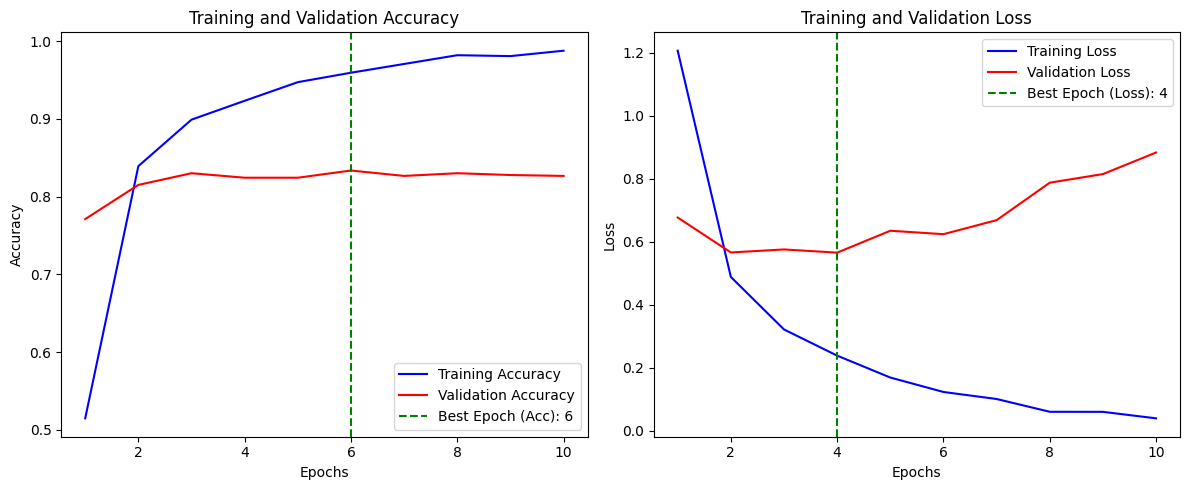


Average Results :
Training Accuracy: 0.8974
Training Loss: 0.2884
Validation Accuracy: 0.8346
Validation Loss: 0.6623
Macro F1: 0.8231
Macro Precision: 0.8336
Macro Recall: 0.8193
Results saved to /kaggle/working/results_roberta_goe_raw.csv


In [78]:
csv_filename = '/kaggle/working/results_roberta_goe_raw.csv'

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=goe_train_x_raw,
    train_y=goe_train_y_raw,
    train_y_ohe=goe_train_y_ohe_raw,
    model_name='roberta',
    dataset='GOE',
    dataset_type='raw',
    batch_size=16
)

In [79]:
test_df = pd.read_csv('/kaggle/working/results_roberta_goe_raw.csv')
test_df

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.525708,1.213757,0.801386,0.564388,0.785885,0.800537,0.781272
1,16,1,2,0.833911,0.495538,0.837182,0.553930,0.829792,0.846272,0.820411
2,16,1,3,0.885038,0.359603,0.846420,0.558464,0.837034,0.855743,0.828833
3,16,1,4,0.920566,0.254816,0.829099,0.655741,0.819809,0.834026,0.814579
4,16,1,5,0.943963,0.179449,0.826790,0.718714,0.813789,0.834339,0.806310
5,16,1,6,0.960139,0.129673,0.831409,0.751950,0.818443,0.835115,0.814732
6,16,1,7,0.962738,0.105959,0.826790,0.812660,0.811505,0.839912,0.800737
7,16,1,8,0.974292,0.081218,0.839492,0.789083,0.826616,0.847898,0.820970
8,16,1,9,0.978625,0.062126,0.852194,0.756652,0.842351,0.849403,0.837815
9,16,1,10,0.982380,0.058096,0.848730,0.773472,0.838185,0.842906,0.835396


### ALBERT


Fold 1
Epoch 1/10
28/28 [==============================] - 12s 127ms/step

Epoch 1 - Precision: 0.6948, Recall: 0.6992, F1-Score: 0.6898
217/217 [==============================] - 90s 294ms/step - loss: 1.5000 - categorical_accuracy: 0.4142 - val_loss: 0.8578 - val_categorical_accuracy: 0.7229 - val_precision: 0.6948 - val_recall: 0.6992 - val_f1_score: 0.6898
Epoch 2/10
28/28 [==============================] - 4s 128ms/step

Epoch 2 - Precision: 0.8021, Recall: 0.7920, F1-Score: 0.7938
217/217 [==============================] - 47s 216ms/step - loss: 0.6897 - categorical_accuracy: 0.7724 - val_loss: 0.6321 - val_categorical_accuracy: 0.8072 - val_precision: 0.8021 - val_recall: 0.7920 - val_f1_score: 0.7938
Epoch 3/10
28/28 [==============================] - 4s 129ms/step

Epoch 3 - Precision: 0.8305, Recall: 0.8073, F1-Score: 0.8152
217/217 [==============================] - 46s 213ms/step - loss: 0.4384 - categorical_accuracy: 0.8608 - val_loss: 0.5973 - val_categorical_accuracy: 0

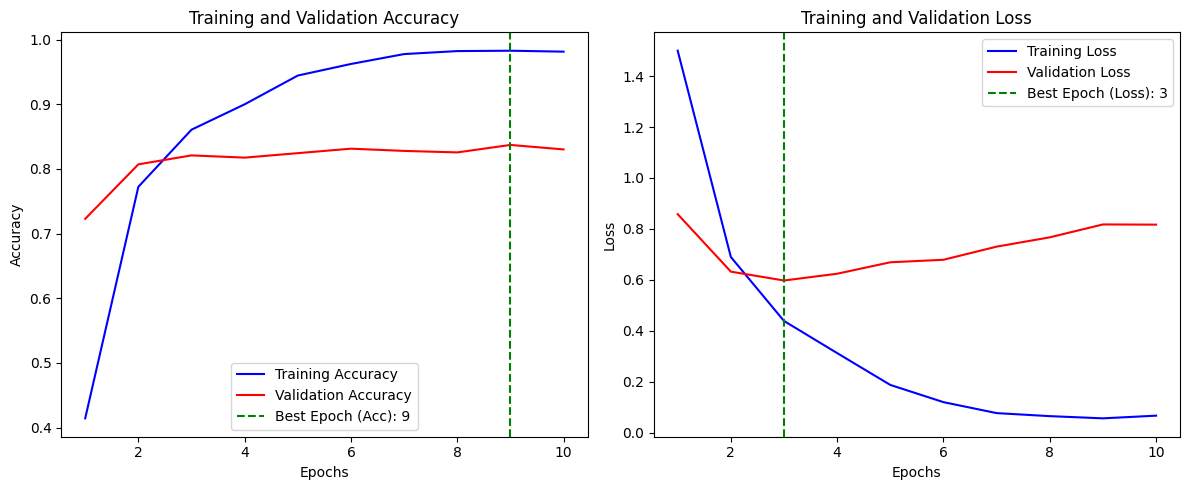

/tmp/ipykernel_29/3166976722.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)



Fold 2
Epoch 1/10
28/28 [==============================] - 12s 126ms/step

Epoch 1 - Precision: 0.5096, Recall: 0.5496, F1-Score: 0.5248
217/217 [==============================] - 96s 298ms/step - loss: 1.5932 - categorical_accuracy: 0.3764 - val_loss: 1.0908 - val_categorical_accuracy: 0.6155 - val_precision: 0.5096 - val_recall: 0.5496 - val_f1_score: 0.5248
Epoch 2/10
  1/217 [..............................] - ETA: 37s - loss: 1.2553 - categorical_accuracy: 0.5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 127ms/step

Epoch 2 - Precision: 0.7782, Recall: 0.7211, F1-Score: 0.7315
217/217 [==============================] - 47s 216ms/step - loss: 0.9625 - categorical_accuracy: 0.6687 - val_loss: 0.7208 - val_categorical_accuracy: 0.7691 - val_precision: 0.7782 - val_recall: 0.7211 - val_f1_score: 0.7315
Epoch 3/10
28/28 [==============================] - 4s 128ms/step

Epoch 3 - Precision: 0.8007, Recall: 0.7653, F1-Score: 0.7769
217/217 [==============================] - 46s 213ms/step - loss: 0.6454 - categorical_accuracy: 0.7880 - val_loss: 0.6221 - val_categorical_accuracy: 0.7968 - val_precision: 0.8007 - val_recall: 0.7653 - val_f1_score: 0.7769
Epoch 4/10
28/28 [==============================] - 4s 127ms/step

Epoch 4 - Precision: 0.7302, Recall: 0.6820, F1-Score: 0.6980
217/217 [==============================] - 46s 214ms/step - loss: 0.5736 - categorical_accuracy: 0.8114 - val_loss: 0.8618 - val_categorical_accuracy: 0.7067 - val_precisio

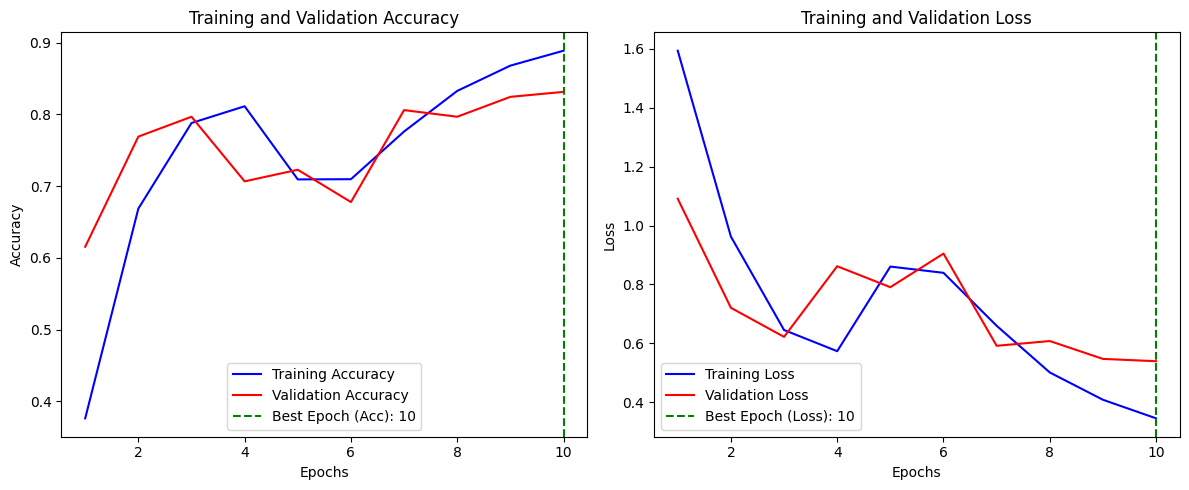


Fold 3
Epoch 1/10
28/28 [==============================] - 12s 126ms/step

Epoch 1 - Precision: 0.7334, Recall: 0.5982, F1-Score: 0.5658
217/217 [==============================] - 91s 294ms/step - loss: 1.5194 - categorical_accuracy: 0.4258 - val_loss: 0.9184 - val_categorical_accuracy: 0.6732 - val_precision: 0.7334 - val_recall: 0.5982 - val_f1_score: 0.5658
Epoch 2/10
28/28 [==============================] - 4s 127ms/step

Epoch 2 - Precision: 0.8240, Recall: 0.8084, F1-Score: 0.8140
217/217 [==============================] - 47s 216ms/step - loss: 0.7438 - categorical_accuracy: 0.7533 - val_loss: 0.5369 - val_categorical_accuracy: 0.8268 - val_precision: 0.8240 - val_recall: 0.8084 - val_f1_score: 0.8140
Epoch 3/10
28/28 [==============================] - 4s 127ms/step

Epoch 3 - Precision: 0.8227, Recall: 0.8203, F1-Score: 0.8185
217/217 [==============================] - 46s 213ms/step - loss: 0.4661 - categorical_accuracy: 0.8484 - val_loss: 0.5416 - val_categorical_accuracy: 0

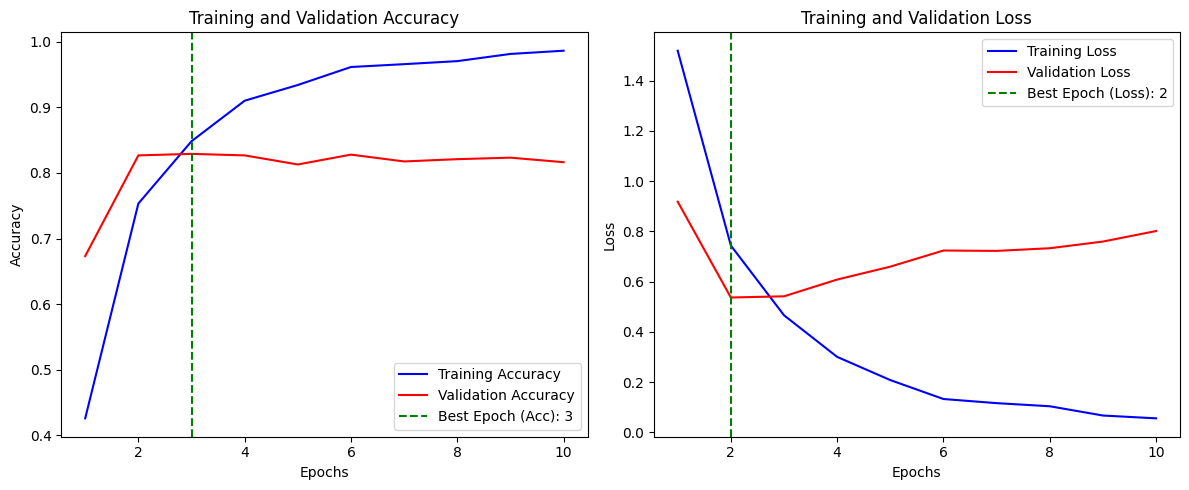


Fold 4
Epoch 1/10
28/28 [==============================] - 12s 126ms/step

Epoch 1 - Precision: 0.7404, Recall: 0.7107, F1-Score: 0.7161
217/217 [==============================] - 90s 294ms/step - loss: 1.4036 - categorical_accuracy: 0.4614 - val_loss: 0.7640 - val_categorical_accuracy: 0.7572 - val_precision: 0.7404 - val_recall: 0.7107 - val_f1_score: 0.7161
Epoch 2/10
28/28 [==============================] - 4s 127ms/step

Epoch 2 - Precision: 0.8148, Recall: 0.7814, F1-Score: 0.7928
217/217 [==============================] - 47s 216ms/step - loss: 0.6214 - categorical_accuracy: 0.8048 - val_loss: 0.6189 - val_categorical_accuracy: 0.8081 - val_precision: 0.8148 - val_recall: 0.7814 - val_f1_score: 0.7928
Epoch 3/10
28/28 [==============================] - 4s 127ms/step

Epoch 3 - Precision: 0.8308, Recall: 0.8059, F1-Score: 0.8149
217/217 [==============================] - 46s 213ms/step - loss: 0.3796 - categorical_accuracy: 0.8830 - val_loss: 0.6135 - val_categorical_accuracy: 0

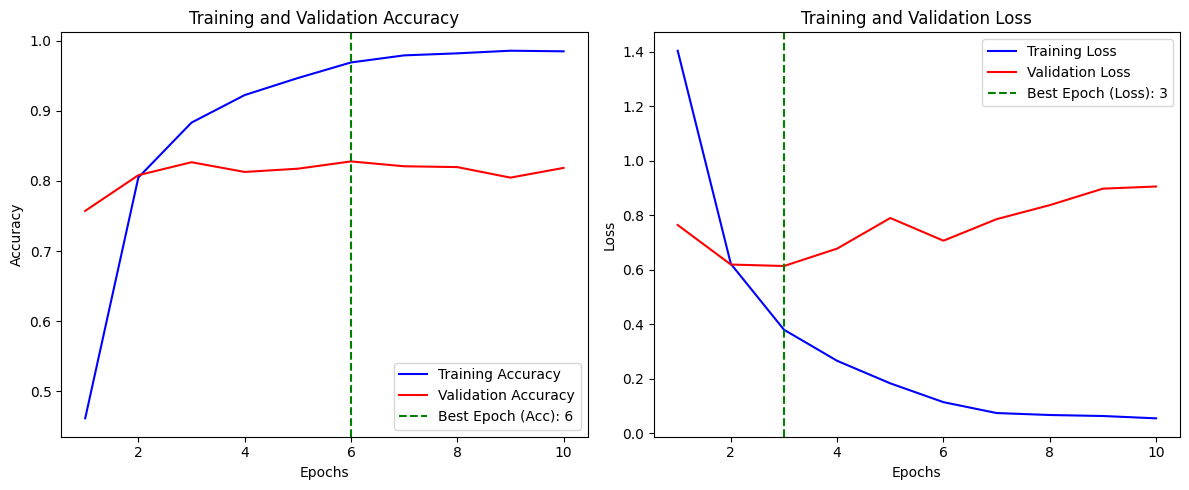


Fold 5
Epoch 1/10
28/28 [==============================] - 13s 126ms/step

Epoch 1 - Precision: 0.7700, Recall: 0.7398, F1-Score: 0.7495
217/217 [==============================] - 95s 318ms/step - loss: 1.4135 - categorical_accuracy: 0.4586 - val_loss: 0.6982 - val_categorical_accuracy: 0.7688 - val_precision: 0.7700 - val_recall: 0.7398 - val_f1_score: 0.7495
Epoch 2/10
28/28 [==============================] - 4s 128ms/step

Epoch 2 - Precision: 0.8062, Recall: 0.8002, F1-Score: 0.8012
217/217 [==============================] - 47s 216ms/step - loss: 0.5828 - categorical_accuracy: 0.8187 - val_loss: 0.5939 - val_categorical_accuracy: 0.8092 - val_precision: 0.8062 - val_recall: 0.8002 - val_f1_score: 0.8012
Epoch 3/10
28/28 [==============================] - 4s 128ms/step

Epoch 3 - Precision: 0.8004, Recall: 0.7913, F1-Score: 0.7947
217/217 [==============================] - 46s 214ms/step - loss: 0.3721 - categorical_accuracy: 0.8862 - val_loss: 0.6394 - val_categorical_accuracy: 0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 4s 128ms/step

Epoch 6 - Precision: 0.8179, Recall: 0.8090, F1-Score: 0.8123
217/217 [==============================] - 47s 215ms/step - loss: 0.5458 - categorical_accuracy: 0.8262 - val_loss: 0.6826 - val_categorical_accuracy: 0.8173 - val_precision: 0.8179 - val_recall: 0.8090 - val_f1_score: 0.8123
Epoch 7/10
28/28 [==============================] - 4s 127ms/step

Epoch 7 - Precision: 0.8192, Recall: 0.8048, F1-Score: 0.8105
217/217 [==============================] - 46s 214ms/step - loss: 0.2415 - categorical_accuracy: 0.9287 - val_loss: 0.7037 - val_categorical_accuracy: 0.8197 - val_precision: 0.8192 - val_recall: 0.8048 - val_f1_score: 0.8105
Epoch 8/10
28/28 [==============================] - 4s 128ms/step

Epoch 8 - Precision: 0.8234, Recall: 0.8027, F1-Score: 0.8098
217/217 [==============================] - 46s 214ms/step - loss: 0.1516 - categorical_accuracy: 0.9587 - val_loss: 0.7612 - val_categorical_accuracy: 0.8197 - val_precisio

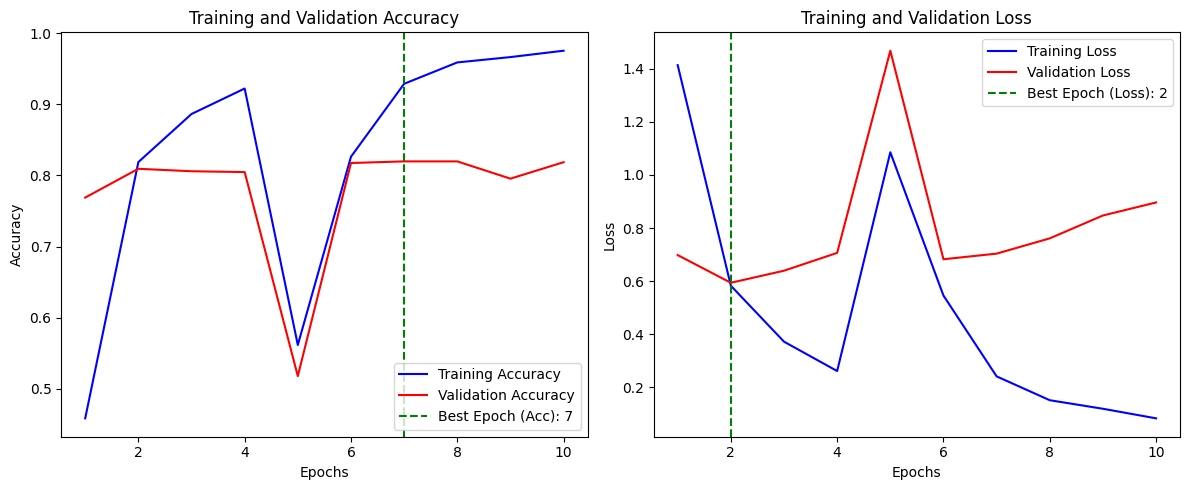


Average Results :
Training Accuracy: 0.8433
Training Loss: 0.4539
Validation Accuracy: 0.7932
Validation Loss: 0.7413
Macro F1: 0.7742
Macro Precision: 0.7910
Macro Recall: 0.7724
Results saved to /kaggle/working/results_albert_goe_raw.csv


In [80]:
csv_filename = '/kaggle/working/results_albert_goe_raw.csv'

training_func_kfold(
    csv_filename=csv_filename,
    csv_columns=csv_columns,
    train_x=goe_train_x_raw,
    train_y=goe_train_y_raw,
    train_y_ohe=goe_train_y_ohe_raw,
    model_name='albert',
    dataset='GOE',
    dataset_type='raw',
    batch_size=16
)

In [81]:
test_df = pd.read_csv('/kaggle/working/results_albert_goe_raw.csv')
test_df

,Batch Size,Fold,Epoch,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Macro F1,Macro Precision,Macro Recall
0,16,1,1,0.414211,1.499982,0.722864,0.857806,0.689754,0.694838,0.699158
1,16,1,2,0.772386,0.689655,0.807159,0.632141,0.793842,0.802127,0.792043
2,16,1,3,0.860774,0.438363,0.821016,0.597345,0.815191,0.830472,0.807336
3,16,1,4,0.900058,0.312206,0.817552,0.623954,0.807560,0.819102,0.802144
4,16,1,5,0.944541,0.187148,0.824480,0.668954,0.815824,0.831999,0.808824
5,16,1,6,0.962449,0.119537,0.831409,0.678774,0.822652,0.835733,0.814228
6,16,1,7,0.977759,0.076485,0.827945,0.730409,0.818937,0.833873,0.812759
7,16,1,8,0.982380,0.064569,0.825635,0.766919,0.817858,0.826956,0.812431
8,16,1,9,0.982958,0.055927,0.837182,0.817570,0.832003,0.838696,0.828159
9,16,1,10,0.981514,0.066449,0.830254,0.816815,0.824606,0.834121,0.819580


In [ ]:
!pkill jupyter